# **Escuela de verano de IA sobre cambio climático: día 3, ciencia climática**
# **Tutorial: Pronóstico estacional**

Traduccion y Challenges resueltos por Cristian Florez y David Peña

Autor original: Ankur Mahesh (UC Berkeley)

# Configuración/Logística


* **Compartir**: según los permisos para compartir, no se le debe permitir realizar ediciones directamente en el cuaderno de Colab compartido. Para realizar modificaciones en este cuaderno, debe presionar Archivo > "Guardar una copia en Drive".
* **Código de andamio**: este cuaderno también pretende servir como ejemplo de la carga y el preprocesamiento de datos necesarios para trabajar con datos climáticos y aprendizaje automático. Lea la "cadena de documentación" para familiarizarse con métodos importantes, como `assemble_predictors_predictands`, y lo que hacen. También le recomendamos encarecidamente que lea el código de los métodos mismos para comprender en detalle los pasos de preprocesamiento de datos.
* **Terminología**: en la conferencia de introducción a la IA impartida por el Dr. Zico Kolter, se utilizaron los términos *entrada* y *etiqueta*. Aquí, nos referimos a la entrada del modelo ML como *predictor* y a la etiqueta como *Predictando*. En este cuaderno, las entradas son temperaturas de la superficie del mar y las etiquetas son un índice que mide el estado futuro de El Niño. (¡más sobre esto a continuación!)



## Introduccion

Ver [aqui](https://docs.google.com/presentation/d/1GeqTg06fBcDXI9ffrvqiMxlnxO12lsHLe_m03N18Kog/edit) para ver algunas diapositivas introductorias.

El Niño/Oscilación del Sur (ENSO) es el modo dominante de variabilidad que afecta el clima en escalas de tiempo estacionales. Se mide mediante el índice Nino3.4, un promedio móvil de tres meses de temperaturas ecuatoriales del Pacífico. ENSO es una oscilación y está marcado por dos fases: El Niño, con temperaturas anormalmente cálidas en el Pacífico ecuatorial, y La Niña, con temperaturas anormalmente frías. Debido a que El Niño está vinculado a muchos patrones climáticos en todo el mundo, como el monzón indio, los huracanes en el Atlántico y la temperatura de América del Norte, los pronósticos precisos de ENSO son valiosos para los sectores sensibles al clima (como la agricultura, el agua y la energía).

Los pronósticos existentes de El Niño utilizan modelos dinámicos del Centro Europeo de Pronósticos Meteorológicos a Plazo Medio y el Centro Nacional de Predicción Ambiental. Estos modelos dinámicos emiten pronósticos modelando la física de la atmósfera y el océano. En este cuaderno, emitiremos pronósticos de ENSO utilizando aprendizaje automático, que utiliza optimización estadística para emitir pronósticos.





## Requisitos de software

Este cuaderno requiere las siguientes bibliotecas: numpy, xarray, netCDF4, pandas, matplotlib, sklearn, tqdm, pytorch, scipy. Además, se recomienda *fuertemente* que utilice este portátil en Google Colab para facilitar su uso y acceder a los recursos de la GPU.

In [5]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
!pip install gdown

## Datos


*   [Cobe Sea-Surface Temperature Dataset:](https://psl.noaa.gov/data/gridded/data.cobe.html): Este es un conjunto de datos de temperaturas históricas de la superficie del mar desde 1880 hasta 2018.
*   [Nino3.4 Indices](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst/): El índice Nino3.4 mide el promedio móvil de tres meses de anomalías de temperatura en el Océano Pacífico ecuatorial.


### Variables de entrada

Tempratura de la supericie del mar (K) tomada en una muestra de latitud y longuitud

### Variable de salida

Indice del Niño 3.4 (K): Esta metrica indica el estado del ENSO.


### Conjunto de entrenamiento

Conjunto de entrenamiento de referencia: Entrenamiento sobre las **temperaturas de la superficie del mar entre 1980 y 1995** y su correspondiente índice del Niño 3.4 en periodos de (1 mes a 5 meses)

### Conjunto de validacion
**Temperaturas de la superficie del mar 1997-2006** y su correspondiente índice del Niño 3.4 en los tiempos de entrega.

### Conjunto de prueba:

Conjunto de prueba sobre las **temperaturas de la superficie del mar 2007-2017** y su correspondiente índice Niño 3.4 en peridos de (1 mes a 5 meses).


### Fundamentos del aprendizaje automático

En esta sección, cubriremos los fundamentos del aprendizaje automático. Nos referiremos a los capítulos de las excelentes notas de clase del profesor Jonathan Shewchuk de CS189 (clase de aprendizaje automático de UC Berkeley), así como a las notas del curso desarrolladas por profesores asistentes como Garrett Thomas y Soroush Nasiriany. Estas notas proporcionan una base matemática rigurosa de los fundamentos del aprendizaje automático y son muy útiles para desarrollar la intuición detrás de abordar los problemas del aprendizaje automático. Si está interesado en profundizar en el aprendizaje automático, le recomiendo encarecidamente leer estos dos recursos.

*   Professor Shewchuk's lecture notes can be found at this [link ](https://people.eecs.berkeley.edu/~jrs/papers/machlearn.pdf)
*   Nasiriany and Thomas's course notes can be found at this [link ](http://snasiriany.me/files/ml-book.pdf)

In [9]:
#Descargue los paquetes requeridos y los datos que usaremos
#para este tutorial

!pip install netCDF4
# !wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
# !wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/nino34.long.anom.data.txt

In [10]:
#Descargar el índice Niño 3.4 (este índice mide el estado de ENSO codificando el promedio
#para la anomalía de temperatura en el Pacífico ecuatorial)
!gdown 1aGvitA8rYrHRDxNd2XD4AAFsahCQsv0t

Downloading...
From: https://drive.google.com/uc?id=1aGvitA8rYrHRDxNd2XD4AAFsahCQsv0t
To: C:\Users\Cristian\Desktop\Estudio IA\ProyectoFinal\nino34.long.anom.data.txt

  0%|          | 0.00/15.4k [00:00<?, ?B/s]
100%|##########| 15.4k/15.4k [00:00<00:00, 15.5MB/s]


In [11]:
#Descargamos las observaciones de temperatura de la superficie marina desde 1880 a 2018
!gdown 1-xefk3imP4Q-8GevIV2YIo82iP5rTdSc

Downloading...
From (original): https://drive.google.com/uc?id=1-xefk3imP4Q-8GevIV2YIo82iP5rTdSc
From (redirected): https://drive.google.com/uc?id=1-xefk3imP4Q-8GevIV2YIo82iP5rTdSc&confirm=t&uuid=34c94b82-c877-44ab-9ba9-381ae69ace1e
To: C:\Users\Cristian\Desktop\Estudio IA\ProyectoFinal\sst.mon.mean.trefadj.anom.1880to2018.nc

  0%|          | 0.00/432M [00:00<?, ?B/s]
  0%|          | 524k/432M [00:00<04:51, 1.48MB/s]
  0%|          | 1.57M/432M [00:00<01:49, 3.93MB/s]
  1%|          | 3.15M/432M [00:00<01:00, 7.15MB/s]
  2%|1         | 7.34M/432M [00:00<00:25, 16.9MB/s]
  2%|2         | 10.5M/432M [00:00<00:20, 20.8MB/s]
  3%|3         | 14.7M/432M [00:00<00:15, 26.4MB/s]
  4%|4         | 17.8M/432M [00:01<00:15, 26.2MB/s]
  5%|5         | 22.0M/432M [00:01<00:13, 29.4MB/s]
  6%|5         | 25.2M/432M [00:01<00:13, 29.4MB/s]
  7%|6         | 28.8M/432M [00:01<00:13, 30.9MB/s]
  8%|7         | 33.0M/432M [00:01<00:12, 32.3MB/s]
  8%|8         | 36.7M/432M [00:01<00:11, 33.0MB/s]
  9%|

In [12]:
#Código de andamio para cargar datos. Esta celda de código es principalmente una disputa de datos.

def load_enso_indices():
  """
  Lee el archivo de datos txt para generar una serie pandas de valores ENSO

  salidas
  -------

    pd.Series : valores mensuales de ENSO a partir del 1870-01-01
  """
  with open('nino34.long.anom.data.txt') as f:
    line = f.readline()
    enso_vals = []
    while line:
        yearly_enso_vals = map(float, line.split()[1:])
        enso_vals.extend(yearly_enso_vals)
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)
  return enso_vals
#Ensamblar predictores basicos
def assemble_basic_predictors_predictands(start_date, end_date, lead_time,
                                    use_pca=False, n_components=32):
  """
  entradas
  ------

      start_date        str : la fecha de inicio a partir de la cual extraer la temperatura de la superficie del mar
      end_date          str : la fecha final
      lead_time         str : el numero de meses entre cada valor de temperatura
                              y el objeto Niño 3.4 Index
      use_pca          bool : si se aplican o no analisis de componentes principales
                              al campo de sst
      n_components      int : el número de componentes a utilizar para ACP

  Salidas
  -------
      Devuelve una tupla de los predictores (matriz np de anomalías de temperatura sst)
       y los predictandos (np establece el índice ENOS en el tiempo de entrega especificado).

  """
  ds = xr.open_dataset('sst.mon.mean.trefadj.anom.1880to2018.nc')
  sst = ds['sst'].sel(time=slice(start_date, end_date))
  num_time_steps = sst.shape[0]

  #la temperatura de la supericie marina es un arreglo 3D: (time_steps, lat, lon)
  #En este tutorial, no usaremos modelos ML que tomen
  #ventaja de la naturaleza espacial de la temperatura global
  #por lo tanto, reducimos la temperatura de la supericie marina
  #en una matriz 2D: (time_steps, lat*lon)
  #(En cada paso de tiempo, hay predictores de lat*lon.)
  sst = sst.values.reshape(num_time_steps, -1)
  sst[np.isnan(sst)] = 0

  #Utilice el análisis de componentes principales, también llamado
  #funciones ortogonales empíricas, para reducir la
  #dimensionalidad de la matriz
  if use_pca:
  #TODO: cree una opción para aplicar la operación PCA aprendida en el conjunto
  #de entrenamiento al conjunto de prueba. Actualmente, la PCA se realiza de
  #forma independiente en el conjunto de trenes y en el conjunto de pruebas.
    pca = sklearn.decomposition.PCA(n_components=n_components)
    pca.fit(sst)
    X = pca.transform(sst)
  else:
    X = sst

  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
  y = load_enso_indices()[slice(start_date_plus_lead,
                                end_date_plus_lead)]


  ds.close()
  return X, y

def plot_nino_time_series(y, predictions, title):
  """
  Entrada
  ------
    y           pd.Series : Serie temporal del verdadero índice de Niño.
    predictions np.array  : Serie temporal del índice de Niño previsto
                            (misma duración y tiempo que y)
    titile                : el título del grafico

  Salida
  -------
    None.  Muestra la salida
  """
  predictions = pd.Series(predictions, index=y.index)
  predictions = predictions.sort_index()
  y = y.sort_index()

  plt.plot(y, label='Verdad fundamental')
  plt.plot(predictions, '--', label='Prediccion ML')
  plt.legend(loc='best')
  plt.title(title)
  plt.ylabel('Indice del Niño 3.4')
  plt.xlabel('Fecha')
  plt.show()
  plt.close()


In [13]:
#Carga de muestras de los conjuntos de entrenamiento, validacion y prueba
X_train, y_train = assemble_basic_predictors_predictands('1980-01-01','1995-12-31', lead_time=1)
X_val, y_val = assemble_basic_predictors_predictands('1997-01-01','2006-12-31', lead_time=1)
X_test, y_test = assemble_basic_predictors_predictands('2007-01-01','2017-12-31', lead_time=1)


# Modelo básico de aprendizaje automático


El modelo referencia de ML será la regresión lineal.



RMSE: 0.28


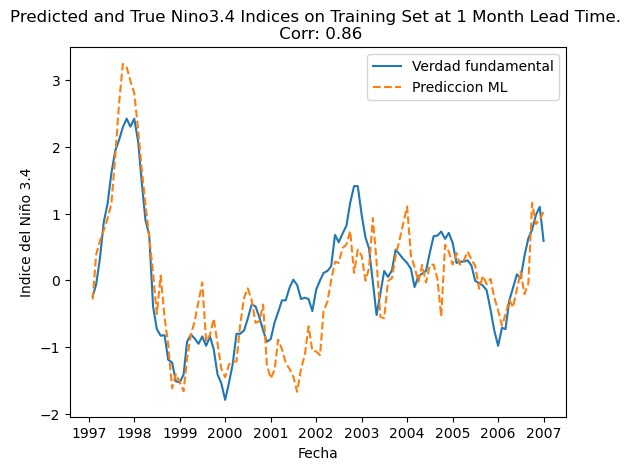

In [15]:
#Vamos a usar un modelo de regresion lineal
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train,y_train)

predictions = regr.predict(X_val)
corr, _ = scipy.stats.pearsonr(predictions, y_val)
rmse = mean_squared_error(y_val, predictions)
print("RMSE: {:.2f}".format(rmse))

plot_nino_time_series(y_val, predictions,
    'Predicted and True Nino3.4 Indices on Training Set at 1 Month Lead Time. \n Corr: {:.2f}'.format(corr))

## Métricas

Las métricas para evaluar este modelo de ML son

*   Correlación de Pearson
*   RMSE

El fragmento de código anterior incluye ejemplos de cálculo.

## Términos clave



Algunos términos:
* predictor: la entrada a un modelo de aprendizaje automático: una cierta cantidad de meses (que usted define) de temperatura cuadriculada)
* predictando: el valor real que el modelo intenta predecir (es decir, el verdadero índice Niño3.4)
* predicción: el resultado del modelo de aprendizaje automático




##Entrenamiento/Validacion/Conjunto de prueba y sobreajuste

Un modelo de aprendizaje automático utiliza optimización estadística para conocer la relación entre los predictores (la entrada) y los predictandos (la etiqueta).
* En este taller, nuestros predictores han sido la temperatura global anormalizada, y nuestra predicción ha sido el Índice El Niño/Oscilación del Sur (ENSO) 3.4 en un tiempo de anticipación.

Llamemos a nuestros predictores $X$ y llamemos a nuestro predictando $y$. Existe una relación desconocida entre $X$ y $Y$. Por ejemplo, existe alguna función desconocida que rige la relación entre la temperatura global y el futuro índice ENSO. El objetivo de un modelo ML es *aproximar* esta función desconocida.

¿Cómo probamos si el modelo ML se ha aproximado correctamente a esta función? Dividimos los datos en un conjunto de entrenamiento y un conjunto de prueba.


* Durante el entrenamiento, al modelo ML se le muestran los predictores y sus predicciones asociadas. El modelo ML utiliza la optimización para aprender una función: dados los predictores de entrenamiento, la función genera los predictandos lo más cerca posible.
* Durante las pruebas, el modelo ML se evalúa en datos invisibles (es decir, el conjunto de prueba). Cuando un modelo funciona bien en el conjunto de entrenamiento y mal en la prueba, el modelo se ha **sobreajustado** al conjunto de entrenamiento.
* Si un modelo tiene un rendimiento deficiente en el conjunto de entrenamiento, este comportamiento se denomina **subajuste**. Durante el subajuste, el modelo no ha aprendido la relación correcta entre los predictores y el predictando.



***Pregunta***: En la imagen de abajo, ¿qué imagen corresponde al sobreajuste? ¿Qué corresponde al desajuste? ¿Y cuál no corresponde a ninguno de los dos?


![alt text](https://scikit-learn.org/stable/_images/sphx_glr_plot_underfitting_overfitting_001.png)






*   La primera corresponde a un subajuste porque no representa muy bien el comportamiento de los datos
*   La tercera corresponde a un sobreajuste, el modelo intenta ajustarse a cada punto de datos es decir se sobrejusta a cada dato.
*   La tercera corresponde al resultado deseado donde nuestro modelo y la funcion verdadera se sobreponen




En la siguiente celda de código, estudiemos el sobreajuste en la siguiente tarea: entrenar un modelo de aprendizaje automático para pronosticar El Niño. El Niño es un ciclo de temperaturas cálidas y frías en el Océano Pacífico ecuatorial que tiene amplias implicaciones para el clima estacional.

La siguiente celda de código demuestra el sobreajuste: obtener un gran rendimiento en el entrenamiento.
Con un plazo de entrega absurdo (¡¡36 meses!!), es posible obtener una correlación perfecta en el conjunto de entrenamiento. Es casi seguro que es imposible hacer pronósticos tan precisos en plazos de entrega tan largos.

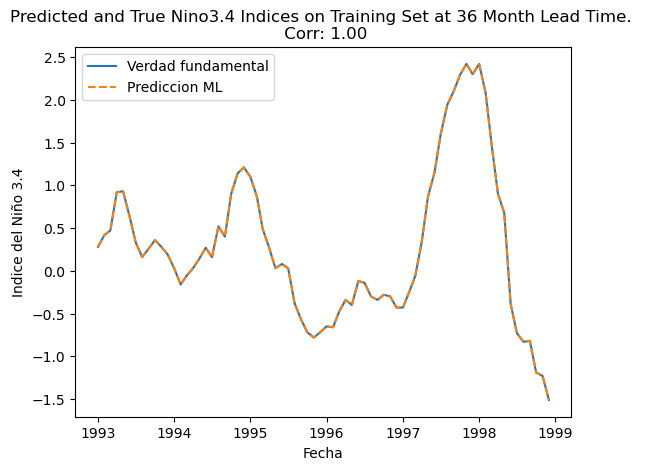

In [23]:
#Cargar los predictores
X, y = assemble_basic_predictors_predictands('1990-01-01','1995-12-31', 36)

#Ahora usamos el modelo de regresion lineal
regr = sklearn.linear_model.LinearRegression()
regr.fit(X,y)

predictions = regr.predict(X)
corr, _ = scipy.stats.pearsonr(predictions, y)

plot_nino_time_series(y, predictions,
    'Predicted and True Nino3.4 Indices on Training Set at 36 Month Lead Time. \n Corr: {:.2f}'.format(corr))

La celda de arriba muestra que es posible obtener un excelente rendimiento del conjunto de entrenamiento, incluso para una tarea muy difícil (36 meses antes de lo previsto por Niño).
Necesitamos evaluar el modelo con datos invisibles para ver si puede **generalizar** bien: ¡es por eso que un conjunto de pruebas es tan crucial!

C:\Users\Cristian\AppData\Local\Temp\ipykernel_31520\2340114141.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X, y = X[permuted_indices], y[permuted_indices]


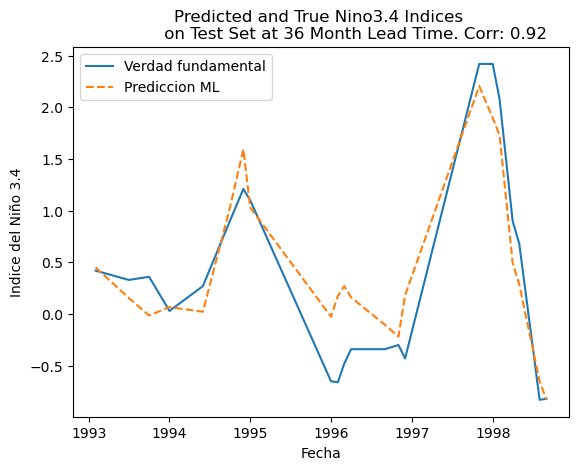

In [25]:
"""Evaluate the model on a randomly selected test set"""
#X tiene forma (num_time_steps, lat*lon)
#y tiene forma (num_time_steps)
np.random.seed(0)

#Mezclar aleatoriamente X e y para dividirlos en un conjunto de entrenamiento y otro de prueba.
num_time_steps = X.shape[0]
permuted_indices = np.random.permutation(np.arange(num_time_steps))

#Conservar el 70% de los datos para el conjunto de pruebas
train_set_proportion = int(0.7 * num_time_steps)
X, y = X[permuted_indices], y[permuted_indices]
X_train, y_train = X[:train_set_proportion], y[:train_set_proportion]
X_test, y_test = X[train_set_proportion:], y[train_set_proportion:]

#En lugar de escribir la lógica de arriba, sklearn también proporciona
#un método incorporado en la línea de abajo.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train,y_train)

predictions_test = regr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)

plot_nino_time_series(y_test, predictions_test,
            'Predicted and True Nino3.4 Indices \n \
            on Test Set at 36 Month Lead Time. Corr: {:.2f}'.format(corr))

¿Qué pasó arriba? ¿Acabamos de desarrollar un pronóstico a 36 meses que tiene una correlación de 0,92 con datos invisibles?

Dividir aleatoriamente los datos de series temporales en un conjunto de entrenamiento y un conjunto de pruebas es muy arriesgado. En muchos conjuntos de datos climáticos, las series temporales tienen una autocorrelación no despreciable. Piénselo así: la atmósfera suele tener una "memoria" de unos 14 días, y el océano tiene aproximadamente una "memoria" de unos 2 años.

Si dividimos aleatoriamente el conjunto de datos en conjunto de entrenamiento y conjunto de pruebas, algunos de los ejemplos del conjunto de pruebas se correlacionarán con los ejemplos del conjunto de entrenamiento. **Esto corrompe nuestro conjunto de pruebas.** Si el conjunto de pruebas está correlacionado con el conjunto de trenes, entonces ya no mide qué tan generalizable es nuestro modelo de ML.

## Ejercicio 1

⭐ **¡Tu turno!:** ¿El rendimiento en un conjunto de pruebas verdadero y no correlacionado será mejor o peor que el rendimiento en el conjunto de datos sesgado? Divida los datos de modo que el conjunto de prueba represente un conjunto de reserva imparcial. Asegúrese de utilizar un plazo de entrega de 36 meses.

RMSE: 1.21


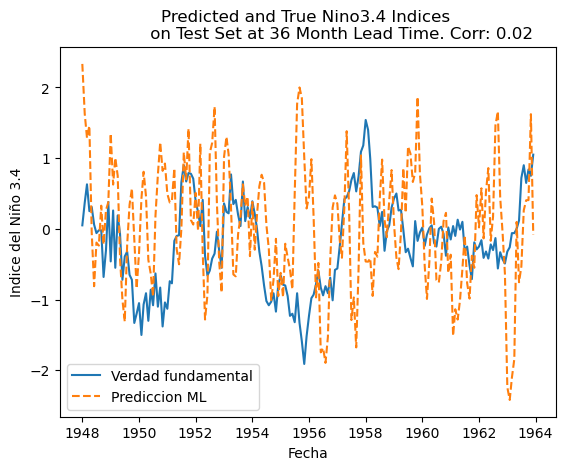

In [28]:
X_train, y_train = assemble_basic_predictors_predictands('1920-01-01','1940-12-31', lead_time=36)
X_test, y_test = assemble_basic_predictors_predictands('1945-01-01','1960-12-31', lead_time=36)

regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train, y_train)

predictions_test = regr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
rmse = mean_squared_error(y_test, predictions_test)
print("RMSE: {:.2f}".format(rmse))

plot_nino_time_series(y_test, predictions_test,
            'Predicted and True Nino3.4 Indices \n \
            on Test Set at 36 Month Lead Time. Corr: {:.2f}'.format(corr))

Observamos un valor alto del RMSE y una correlacion cercana a 0 que nos indicaria que no existe una relacion lineal entre el indice del niño 3.4 y la temperatura de la superficie del mar. Respondiendo a la pregunta su rendimiento para acercarce a la funcion verdadera es bajo

### Introducción y teoría

El comportamiento de los modelos de aprendizaje automático se puede descomponer en dos cantidades:

* **Sesgo**: En el conjunto de entrenamiento, ¿qué tan bien predice la verdad el modelo de aprendizaje automático?
* **Varianza**: a medida que varían los datos de entrada, ¿cómo varía la predicción del aprendizaje automático? Para un pequeño cambio en los predictores de entrada, ¿cuánto cambiaría la predicción de ML?

Miremos la figura anterior una vez más:
![texto alternativo](https://scikit-learn.org/stable/_images/sphx_glr_plot_underfitting_overfitting_001.png)


La imagen de la izquierda utiliza un modelo lineal para aproximar una "función verdadera" no lineal. Por lo tanto, el modelo lineal no comprende bien la función y tiene un alto sesgo. De manera similar, tiene una varianza baja, porque pequeños cambios en los puntos de muestra a lo largo de la curva no cambiarán el modelo lineal.


***Pregunta***
1. ¿La imagen de la derecha tiene un sesgo alto o bajo?
Tiene un Sesgo bajo ya que predice la funcion verdadera muy bien
2. ¿La imagen de la derecha tiene una variación alta o baja?
tiene una alta variacion, es decir que si cambialos los datos de entrada el modelo cambia



Con base en las figuras anteriores, concluimos que el sesgo y la varianza son a menudo una compensación: los modelos con un alto sesgo a menudo tienen una varianza baja, y viceversa. Consulte la página 23 de las notas de Nasiriany para obtener una derivación matemática de esta compensación.


Aquí hay otro ejemplo para ayudar a desarrollar nuestra comprensión visual del sesgo vs. diferencia.

Así es como funciona un modelo de k-vecino más cercano:
1. Al modelo se le muestra un punto de datos de muestra del conjunto de prueba, $x_\text{test}$
2. Busca en su conjunto de entrenamiento los $k$ puntos de datos más similares
3. De los $k$ puntos que encuentra, calcula el predictando más común y asigna $x_\text{test}$ al más común.

Fundamentalmente, este método admite la clasificación de datos que no son separables linealmente (consulte la imagen a continuación para ver un ejemplo).

***Pregunta de encuesta:*** Para un valor grande de $k$, ¿esperaría un clasificador de alto sesgo/baja varianza? ¿O un clasificador de alta varianza/bajo sesgo?

Se esperaria un calsificador de ***alto sesgo*** porque puede que no represente muy bien la funcion verdadera en los casos de $k$ muy grande ya que para asignar el valor al valor del predictando puede que use valores muy alejados y estos influyan en la determinacion de su clasificacion. Una ***baja varianza*** porque al ser $k$ muy grande el ingreso de un dato no alteraria la prediccion del modelo.

![texto alternativo](https://miro.medium.com/v2/resize:fit:828/format:webp/1*HmuYl9VQX9pzCL4KLmILrg.png)

![texto alternativo](http://web.cse.ohio-state.edu/~stiff.4/cse3521/images/effect-of-k.png)



Conectemos el equilibrio entre sesgo y varianza con la discusión que tuvimos sobre el sobreajuste en la primera sección. Implicaciones del equilibrio entre sesgo y varianza (de Wikipedia)

* "El error de sesgo es un error debido a suposiciones erróneas en el algoritmo de aprendizaje. Un sesgo alto puede hacer que un algoritmo pierda las relaciones relevantes entre las características y los resultados objetivo (**subajuste**)".

* "La varianza es un error de la sensibilidad a pequeñas fluctuaciones en el conjunto de entrenamiento. Una varianza alta puede hacer que un algoritmo modele el ruido aleatorio en los datos de entrenamiento, en lugar de los resultados previstos (**sobreajuste**)".

### Regularización

Nuestro objetivo en el aprendizaje automático es evitar el subajuste y el sobreajuste: queremos desarrollar modelos que funcionen bien tanto en el conjunto de entrenamiento como en el conjunto de prueba.

Un método para evitar el sobreajuste es la **regularización.** En la siguiente sección, discutiremos cómo la regularización evita el sobreajuste.   

Sea $X$ una matriz 2D de forma $(n,d)$ donde $n$ es el número de pasos temporales y $d$ es el número de predictores.  Sea $y$ un vector de forma $(n,1)$ que tiene los valores ENSO objetivo.  Sea $w$ un vector de forma $(d,1)$.

En la regresión lineal por mínimos cuadrados ordinarios, estamos **encontrando el valor de $w$** que minimiza el siguiente término:

$$\text{min}||Xw-y||^2 $$


He aquí una descripción intuitiva de las matemáticas anteriores:
* el objetivo de la regresión lineal es minimizar la diferencia al cuadrado entre las predicciones de los modelos lineales ($Xw$) y la verdad ($y$).

La predicción de un modelo de regresión lineal es $Xw$.  He aquí una descripción intuitiva de lo que es $Xw$:
* un modelo de regresión lineal hace un pronóstico multiplicando cada predictor por su peso asociado y devolviendo la suma de estos productos. Con pesos grandes, un pequeño cambio en uno de los predictores provocará un gran cambio en la prediccion.  Por lo tanto, modificamos la regresión lineal para penalizar el modelo de aprendizaje de grandes pesos:


$$\text{min}||Xw-y||^2 + \alpha ||w||^2 $$


$\alpha ||w||^2$ se denomina término de regularización. Esta forma regularizada de regresión lineal suele denominarse **Regresión de Cresta**.

Consulte la página 6 de Nasiriany para ver las derivaciones matemáticas de las soluciones de los dos problemas de minimización anteriores.


### *Ejercicio de codificación*: Regularización


En este ejemplo, investigaremos el efecto real de la regularización en nuestro conjunto de datos ENSO.

Nota: para efectos de visualización, no entrenamos nuestros modelos utilizando todos los predictores lat$*$lon.  En su lugar, utilizamos el análisis de componentes principales (también conocido como funciones ortogonales empíricas) para representar todos los predictores lat$*$lon con muchas menos dimensiones.  Por falta de tiempo, consulte la página 116 de los apuntes del profesor Shewchuk para obtener una explicación más detallada de este método.

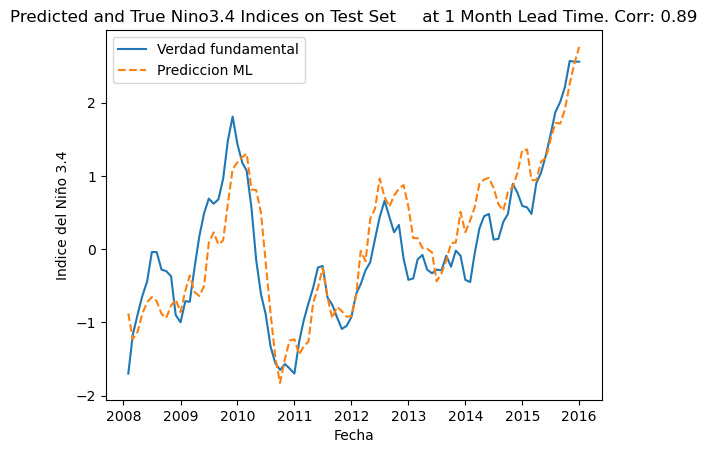

In [34]:
X_train, y_train = assemble_basic_predictors_predictands('1990-01-01','2005-12-31',
                                                1,use_pca=True)
X_test, y_test = assemble_basic_predictors_predictands('2008-01-01','2015-12-31', 1,
                                                  use_pca=True)
regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_lr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set \
    at 1 Month Lead Time. Corr: {:.2f}'.format(corr))


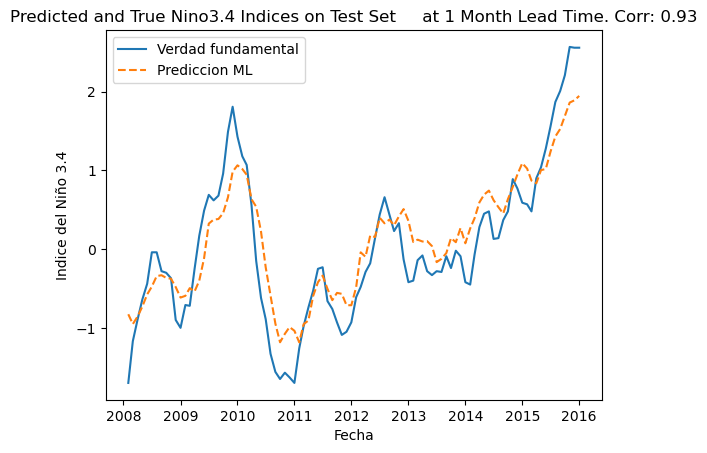

In [35]:
X_train, y_train = assemble_basic_predictors_predictands('1990-01-01','2005-12-31',
                                                1,use_pca=True)
X_test, y_test = assemble_basic_predictors_predictands('2008-01-01','2015-12-31', 1,
                                                  use_pca=True)
regr_1_month_ridge = sklearn.linear_model.Ridge(alpha=80000.0)
regr_1_month_ridge.fit(X_train,y_train)

#En primer lugar, vamos a graficar el rendimiento del modelo
predictions_test = regr_1_month_ridge.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set \
    at 1 Month Lead Time. Corr: {:.2f}'.format(corr))


En el conjunto de pruebas vemos que el modelo regularizado funciona ligeramente mejor que el modelo lineal. Esto es una buena señal, ya que el objetivo de la regularización es desarrollar modelos que puedan **generalizar** mejor los datos no vistos.

A continuación, vamos a visualizar y comparar la varianza de los dos modelos.  Recordemos que los modelos que son muy variables son susceptibles a pequeñas fluctuaciones en los predictores.  En la celda de código siguiente, realizamos el experimento:

* Perturbe los predictores del conjunto de prueba multiplicándolos por un número aleatorio entre -1,05 y 1,05.
* Ejecute los modelos de regresión de cresta y regresión lineal con los predictores perturbados.
* Registre la dispersión de las predicciones

La dispersión de estas predicciones es la varianza del modelo ML.

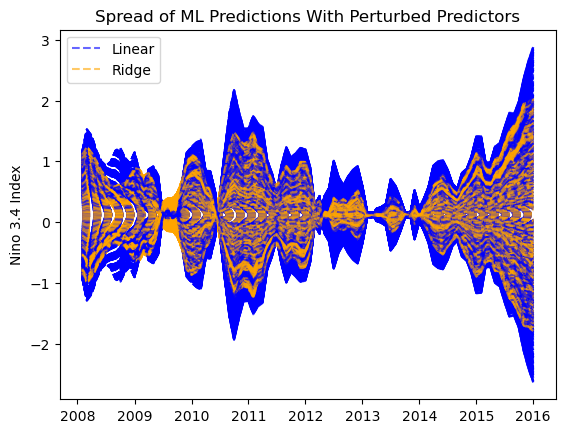

In [37]:
"""En esta celda, visualizaremos la varianza de la regresión lineal y la regresión ridge"""
for experiment_num in range(1000):
  perturbed_X_test = X_test * np.random.uniform(-1.05,1.05)

  perturbed_predictions_linear = regr_1_month_lr.predict(perturbed_X_test)
  perturbed_predictions_linear = pd.Series(perturbed_predictions_linear,
                                           index=y_test.index)
  plt.plot(perturbed_predictions_linear, '--', label='Linear', color='blue',
           alpha=0.6)

  perturbed_predictions_ridge = regr_1_month_ridge.predict(perturbed_X_test)
  perturbed_predictions_ridge = pd.Series(perturbed_predictions_ridge,
                                           index=y_test.index)
  plt.plot(perturbed_predictions_ridge, '--', label='Ridge', color='orange',
           alpha=0.6)

  if experiment_num == 0: plt.legend(loc='best')

plt.title("Spread of ML Predictions With Perturbed Predictors")
plt.ylabel("Nino 3.4 Index")
plt.show()

El gráfico anterior ilustra el efecto de la regularización.  Al perturbar aleatoriamente la entrada 1000 veces, las predicciones de la regresión lineal (azul) tienen una dispersión mayor que las de la regresión de cresta (naranja).  Esto significa que la regresión lineal tiene una varianza mayor que la regresión de cresta.  

En la celda siguiente, vamos a investigar por qué la regresión de cresta es menos vulnerable a las pequeñas fluctuaciones de los datos.

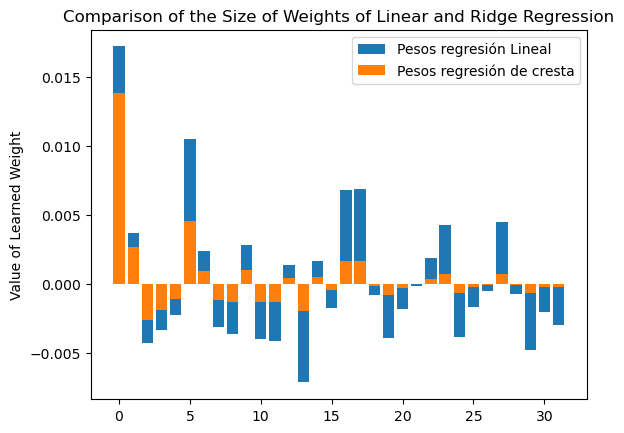

In [39]:
"""En esta celda, visualizaremos cómo los pesos del modelo de regresión lineal
son mayores que las del modelo de regresión de cresta."""

#coef_ loads en los coeficientes del modelo entrenado
regr_1_month_lr_weights = regr_1_month_lr.coef_
regr_1_month_ridge_weights = regr_1_month_ridge.coef_

plt.bar(range(regr_1_month_lr_weights.shape[0]), regr_1_month_lr_weights,
        label='Pesos regresión Lineal')
plt.bar(range(regr_1_month_ridge_weights.shape[0]), regr_1_month_ridge_weights,
        label='Pesos regresión de cresta')
plt.legend(loc='best')
plt.ylabel('Value of Learned Weight')
plt.title('Comparison of the Size of Weights of Linear and Ridge Regression')
plt.show()

Como era de esperar, las ponderaciones del modelo de regresión de cresta son menores que las del modelo de regresión lineal.

Ya lo tenemos. En nuestro conjunto de datos ENSO del mundo real, hemos confirmado nuestras especulaciones teóricas sobre el efecto de la regularización en el equilibrio entre sesgo y varianza.  

Recapitulemos:

* Debido al término de regularización, los pesos en un modelo de regresión de cresta son más pequeños (los pesos grandes se penalizan durante la optimización) que los de la regresión lineal.
* Con pesos más pequeños, el modelo de regresión en cresta es menos vulnerable a las pequeñas fluctuaciones de los datos.
* Esto significa que los modelos de regresión en cresta tienen menos varianza y son menos vulnerables al sobreajuste.

## Modelos de aprendizaje automático y selección de modelos

### Aprendizaje automático basado en la física

Un problema abierto en el aprendizaje automático es cómo incorporar la física al modelo.  Por ejemplo, algunas leyes físicas del sistema climático son la **conservación de la masa** y la **conservación del momento.** Al incluir estas leyes físicas en el aprendizaje automático, podemos obtener dos posibles beneficios:  

* la salida de nuestro modelo de aprendizaje automático es coherente con las propiedades físicas (por ejemplo, no tendremos modelos ML que predigan valores negativos de precipitación).
* Posiblemente, nos lleve menos tiempo entrenar los modelos ML, ya que estamos incluyendo información previa.

La incorporación de la física a los modelos de aprendizaje automático es un área de investigación puntera.  Para más información sobre este ámbito, le sugerimos que lea el siguiente artículo:[ Physics-informed machine learning: case studies for weather and climate modelling.](https://royalsocietypublishing.org/doi/10.1098/rsta.2020.0093)

**Ejercicio para llevar a casa:** ¡Intenta incorporar las leyes físicas a nuestro modelo de previsión ENSO anterior!

### Escala de varianza

En la presentación sobre el preprocesamiento, analizamos las formas en que se normalizan los datos antes de introducirlos en los modelos de aprendizaje automático. Algunos modelos de técnicas de aprendizaje automático requieren que los datos estén centrados (que tengan una media de 0); en otros casos, la normalización ayuda con la estabilidad numérica.

Un tipo de normalización se denomina escala de varianza. La escala de varianza consiste en escalar la varianza de cada predictor de modo que cada predictor tenga una varianza de 1.

En nuestro conjunto de datos ENSO, tenemos predictores latxlon; cada predictor es la temperatura en un lugar determinado de la Tierra.  Tenemos ``num_time_steps`` muestras de estos predictores. Por lo tanto, la forma de ```X`` es (num_time_steps, latxlon). *El escalado de la varianza significaría que escalamos nuestro conjunto de datos de forma que la varianza de la temperatura en cada celda de la cuadrícula sea 1.*

¿Deberíamos utilizar la escala de varianza para nuestro modelo de pronóstico ENSO?

Agradecimiento: Me gustaría agradecer a la profesora [Patrick Brown](https://patricktbrown.org/about/) Por ayudarme con este problema.

In [44]:
"""Write code to explore the above question"""

'Write code to explore the above question'

## Aprendizaje profundo

Ahora vamos a intentar entrenar una red neuronal para predecir el ENSO.  En esta sección, utilizaremos PyTorch como nuestro marco de aprendizaje automático.



Empecemos: primero, carguemos los datos.  **Es esencial entender los argumentos de esta función ya que exploraremos diferentes cuestiones científicas y de aprendizaje automático más adelante en este hackathon.

En esta sección, el método `assemble_predictors_predictands` ha sido extendido para cargar datos de observaciones Y de GCMs.

In [47]:
#Código de andamiaje para cargar datos.  Esta celda de código es en su mayoría de datos wrangling


def load_enso_indices():
  """
  Lee el archivo de datos txt para generar una serie de valores ENSO de pandas

  outputs
  -------

    pd.Series : Valores mensuales de ENSO a partir del 1 de enero de 1870
  """
  with open('nino34.long.anom.data.txt') as f:
    line = f.readline()
    enso_vals = []
    while line:
        yearly_enso_vals = map(float, line.split()[1:])
        enso_vals.extend(yearly_enso_vals)
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)
  return enso_vals

def assemble_predictors_predictands(start_date, end_date, lead_time,
                                    dataset, data_format,
                                    num_input_time_steps=1,
                                    use_pca=False, n_components=32,
                                    lat_slice=None, lon_slice=None):
  """
  inputs
  ------
      start_date           str : La fecha de inicio a partir de la cual extraer la temperatura de la superficie del mar
      end_date             str : La fecha final
      lead_time            str : El numero de meses entre cada valor de temperatura
                                y el objeto Niño 3.4 Index
      dataset              str : 'Observaciones' 'CNRM' or 'MPI'
      data_format          str : 'Espacial' o 'aplanar'. 'Espacial' conserva
                                  las dimensiones lat/lon y devuelve un
                                  matriz de forma (num_samples, num_input_time_steps,
                                  lat, lon).  'Aplanar' devuelve una matriz de forma
                                  (num_samples, num_input_time_steps*lat*lon)
      num_input_time_steps int : el número de pasos temporales a utilizar para cada
                                 muestra predictora
      use_pca             bool : si se aplican o no analisis de componentes principales
                              al campo de sst
      n_components         int : el número de componentes a utilizar para ACP
      lat_slice           slice: La porción de latitudes a utilizar
      lon_slice           slice: La porción de longitudes a utilizar

  outputs
  -------
      Devuelve una tupla de los predictores (matriz np de anomalías de temperatura de la superficie del mar)
y los predictandos (matriz np del índice ENSO en el tiempo de entrega especificado).

  """
  file_name = {'observations' : 'sst.mon.mean.trefadj.anom.1880to2018.nc',
               'CNRM'         : 'CNRM_tas_anomalies_regridded.nc',
               'MPI'          : 'MPI_tas_anomalies_regridded.nc'}[dataset]
  variable_name = {'observations' : 'sst',
                   'CNRM'         : 'tas',
                   'MPI'          : 'tas'}[dataset]
  ds = xr.open_dataset(file_name)
  sst = ds[variable_name].sel(time=slice(start_date, end_date))
  if lat_slice is not None:
      sst = sst.sel(lat=lat_slice)
  if lon_slice is not None:
      sst = sst.sel(lon=lon_slice)


  num_samples = sst.shape[0]
  #sst is a (num_samples, lat, lon) array
  #the line below converts it to (num_samples, num_input_time_steps, lat, lon)
  sst = np.stack([sst.values[n-num_input_time_steps:n] for n in range(num_input_time_steps,
                                                              num_samples+1)])
  #CHALLENGE: CAN YOU IMPLEMENT THE ABOVE LINE WITHOUT A FOR LOOP?
  num_samples = sst.shape[0]

  sst[np.isnan(sst)] = 0
  if data_format=='flatten':
    #sst is a 3D array: (time_steps, lat, lon)
    #in this tutorial, we will not be using ML models that take
    #advantage of the spatial nature of global temperature
    #therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
    #(At each time step, there are lat*lon predictors)
    sst = sst.reshape(num_samples, -1)


    #Use Principal Components Analysis, also called
    #Empirical Orthogonal Functions, to reduce the
    #dimensionality of the array
    if use_pca:
      pca = sklearn.decomposition.PCA(n_components=n_components)
      pca.fit(sst)
      X = pca.transform(sst)
    else:
      X = sst
  else: # data_format=='spatial'
    X = sst

  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time+num_input_time_steps-1)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
  if dataset == 'observations':
    y = load_enso_indices()[slice(start_date_plus_lead,
                                  end_date_plus_lead)]
  else: #the data is from a GCM
    X = X.astype(np.float32)
    #The Nino3.4 Index is composed of three month rolling values
    #Therefore, when calculating the Nino3.4 Index in a GCM
    #we have to extract the two months prior to the first target start date
    target_start_date_with_2_month = start_date_plus_lead - pd.DateOffset(months=2)
    subsetted_ds = ds[variable_name].sel(time=slice(target_start_date_with_2_month,
                                                   end_date_plus_lead))
    #Calculate the Nino3.4 index
    y = subsetted_ds.sel(lat=slice(5,-5), lon=slice(360-170,360-120)).mean(dim=('lat','lon'))

    y = pd.Series(y.values).rolling(window=3).mean()[2:].values
    y = y.astype(np.float32)
  ds.close()
  return X.astype(np.float32), y.astype(np.float32)


class ENSODataset(Dataset):
    def __init__(self, predictors, predictands):
        self.predictors = predictors
        self.predictands = predictands
        assert self.predictors.shape[0] == self.predictands.shape[0], \
               "The number of predictors must equal the number of predictands!"

    def __len__(self):
        return self.predictors.shape[0]

    def __getitem__(self, idx):
        return self.predictors[idx], self.predictands[idx]

**Información IMPORTANTE sobre `num_input_time_steps`:** `num_input_time_steps` se refiere al número de pasos de tiempo para cada predictor.  Por ejemplo, si `num_input_time_steps` se establece en 3, el modelo de aprendizaje automático tomará 3 meses como entrada.  En otras palabras, un predictor de muestra será 3 meses de temperatura media: Temperatura media de enero, temperatura media de febrero y temperatura media de marzo (es decir, una matriz de (3, lat, lon)).  El predictor será el índice Niño 3.4 `lead_time` meses después de marzo.

Para empezar, definamos una red neuronal convolucional sencilla.  

## Entrenar una red neuronal convolucional simple para pronosticar ENSO

Definamos una arquitectura de red neuronal convolucional simple. Esta arquitectura tiene una capa convolucional, seguida de una capa de agrupamiento, seguida de otra capa convolucional, seguida de tres capas completamente conectadas (llamadas capas `nn.Linear`). El resultado de la capa final completamente conectada es una matriz unidimensional, ya que estamos tratando de pronosticar un valor: el índice ENSO objetivo.



In [50]:
class CNN(nn.Module):
    def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
        """
        inputs
        -------
            num_input_time_steps        (int) : the number of input time
                                                steps in the predictor
            print_feature_dimension    (bool) : whether or not to print
                                                out the dimension of the features
                                                extracted from the conv layers
        """
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(num_input_time_steps, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.print_layer = Print()

        #TIP: mprimir la dimensión de las características extraídas de
        #las capas conv para establecer la dimensión de la capa lineal
        #Usando print_layer, encontramos que las dimensiones son
        #(tamaño_lote, 16, 42, 87)
        self.fc1 = nn.Linear(16 * 42 * 87, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.print_feature_dimension = print_feature_dimension

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self.print_feature_dimension:
          x = self.print_layer(x)
        x = x.view(-1, 16 * 42 * 87)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Print(nn.Module):
    """
    Esta clase imprime el tamaño de las características
    """
    def forward(self, x):
        print(x.size())
        return x

A continuación, vamos a definir un método que entrene nuestra red neuronal.  

**IMPORTANTE** ¡Leer este método te ayudará a entender cada paso del proceso de entrenamiento de una red neuronal!

**PREGUNTA PARA DISCUSIÓN EN GRUPO**: ¿Qué pasaría si quitaras las líneas que dicen `if mode == 'train'` en la celda de código de abajo?

In [52]:
def train_network(net, criterion, optimizer, trainloader, testloader,
                  experiment_name, num_epochs=40, classification=False):
  """
  inputs
  ------

      net               (nn.Module)   : the neural network architecture
      criterion         (nn)          : the loss function (i.e. root mean squared error)
      optimizer         (torch.optim) : the optimizer to use update the neural network
                                        architecture to minimize the loss function
      trainloader       (torch.utils.data.DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the train dataset
      testloader        (torch.utils.data. DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the test dataset
      classification              bool  :that takes in a boolean value indicating
                                        whether or not to map the target to 0 or 1.
  outputs
  -------
      predictions (np.array), and saves the trained neural network as a .pt file
  """
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  net = net.to(device)
  best_loss = np.infty
  train_losses, test_losses = [], []

  for epoch in range(num_epochs):
    for mode, data_loader in [('train', trainloader), ('test', testloader)]:
      #Set the model to train mode to allow its weights to be updated
      #while training
      if mode == 'train':
        net.train()

      #Set the model to eval model to prevent its weights from being updated
      #while testing
      elif mode == 'test':
        net.eval()

      running_loss = 0.0
      for i, data in enumerate(data_loader):
          # get a mini-batch of predictors and predictands
          batch_predictors, batch_predictands = data
          if classification:
              batch_predictands = (batch_predictands > 0).float()
          batch_predictands = batch_predictands.to(device)
          batch_predictors = batch_predictors.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          #calculate the predictions of the current neural network
          predictions = net(batch_predictors).squeeze()
          #quantify the quality of the predictions using a
          #loss function (aka criterion) that is differentiable
          loss = criterion(predictions, batch_predictands)

          if mode == 'train':
            #the 'backward pass: calculates the gradients of each weight
            #of the neural network with respect to the loss
            loss.backward()

            #the optimizer updates the weights of the neural network
            #based on the gradients calculated above and the choice
            #of optimization algorithm
            optimizer.step()

          #Save the model weights that have the best performance!


          running_loss += loss.item()
      if running_loss < best_loss and mode == 'test':
          best_loss = running_loss
          torch.save(net, '{}.pt'.format(experiment_name))
      print('{} Set: Epoch {:02d}. loss: {:3f}'.format(mode, epoch+1, \
                                            running_loss/len(data_loader)))
      if mode == 'train':
          train_losses.append(running_loss/len(data_loader))
      else:
          test_losses.append(running_loss/len(data_loader))

  net = torch.load('{}.pt'.format(experiment_name))
  net.eval()
  net.to(device)

  #the remainder of this notebook calculates the predictions of the best
  #saved model
  predictions = np.asarray([])
  for i, data in enumerate(testloader):
    batch_predictors, batch_predictands = data
    if classification:
          batch_predictands = (batch_predictands > 0).float()
    batch_predictands = batch_predictands.to(device)
    batch_predictors = batch_predictors.to(device)

    batch_predictions = net(batch_predictors).squeeze()

    #Edge case: if there is 1 item in the batch, batch_predictions becomes a float
    #not a Tensor. the if statement below converts it to a Tensor
    #so that it is compatible with np.concatenate
    if len(batch_predictions.size()) == 0:
      batch_predictions = torch.Tensor([batch_predictions])
    predictions = np.concatenate([predictions, batch_predictions.detach().cpu().numpy()])
  return predictions, train_losses, test_losses


In [53]:
#Assemble numpy arrays corresponding to predictors and predictands
train_start_date = '1960-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 2
lead_time = 2
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)

#Convert the numpy ararys into ENSODataset, which is a subset of the
#torch.utils.data.Dataset class.  This class is compatible with
#the torch dataloader, which allows for data loading for a CNN
train_dataset = ENSODataset(train_predictors, train_predictands)
test_dataset = ENSODataset(test_predictors, test_predictands)

#Create a torch.utils.data.DataLoader from the ENSODatasets() created earlier!
#the similarity between the name DataLoader and Dataset in the pytorch API is unfortunate...
trainloader = DataLoader(train_dataset, batch_size=10)
testloader = DataLoader(test_dataset, batch_size=10)
net = CNN(num_input_time_steps=num_input_time_steps)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

experiment_name = "twolayerCNN_{}_{}".format(train_start_date, train_end_date)
predictions, train_losses, test_losses = train_network(net, nn.MSELoss(),
                  optimizer, trainloader, testloader, experiment_name)

C:\Users\Cristian\AppData\Local\Temp\ipykernel_31520\2778238354.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self.predictors[idx], self.predictands[idx]
C:\Users\Cristian\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


train Set: Epoch 01. loss: 0.639116
test Set: Epoch 01. loss: 0.609685
train Set: Epoch 02. loss: 0.288615
test Set: Epoch 02. loss: 0.275130
train Set: Epoch 03. loss: 0.175032
test Set: Epoch 03. loss: 0.261209
train Set: Epoch 04. loss: 0.131623
test Set: Epoch 04. loss: 0.163656
train Set: Epoch 05. loss: 0.108949
test Set: Epoch 05. loss: 0.162202
train Set: Epoch 06. loss: 0.090167
test Set: Epoch 06. loss: 0.357180
train Set: Epoch 07. loss: 0.075317
test Set: Epoch 07. loss: 0.360345
train Set: Epoch 08. loss: 0.076243
test Set: Epoch 08. loss: 0.300889
train Set: Epoch 09. loss: 0.104264
test Set: Epoch 09. loss: 0.301628
train Set: Epoch 10. loss: 0.110784
test Set: Epoch 10. loss: 0.164934
train Set: Epoch 11. loss: 0.141081
test Set: Epoch 11. loss: 0.157885
train Set: Epoch 12. loss: 0.101980
test Set: Epoch 12. loss: 0.167431
train Set: Epoch 13. loss: 0.096335
test Set: Epoch 13. loss: 0.218374
train Set: Epoch 14. loss: 0.083229
test Set: Epoch 14. loss: 0.205207
train 

C:\Users\Cristian\AppData\Local\Temp\ipykernel_31520\2722663418.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load('{}.pt'.format(experiment_name))


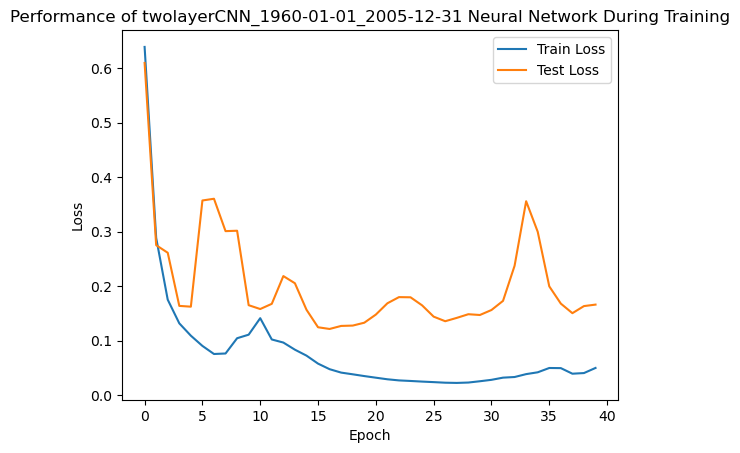

In [54]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of {} Neural Network During Training'.format(experiment_name))
plt.legend(loc='best')
plt.show()

*Comprueba tu comprensión:* De la sección anterior sobre los fundamentos del aprendizaje automático, ¿cómo se llama cuando las pérdidas de validación son muy altas y las pérdidas de entrenamiento son muy bajas? ¿Qué podríamos intentar para reducir este problema?
Podemos determinar que hay un sobreajuste ya que la funcion de perdida para los datos de entrenamiento nos muestra que se ajusto bien a los datos, pero en el caso de la funcion de perdida para los datos de validacion presenta grandes oscilaciones es decir que no generaliza bien los datos de prueba

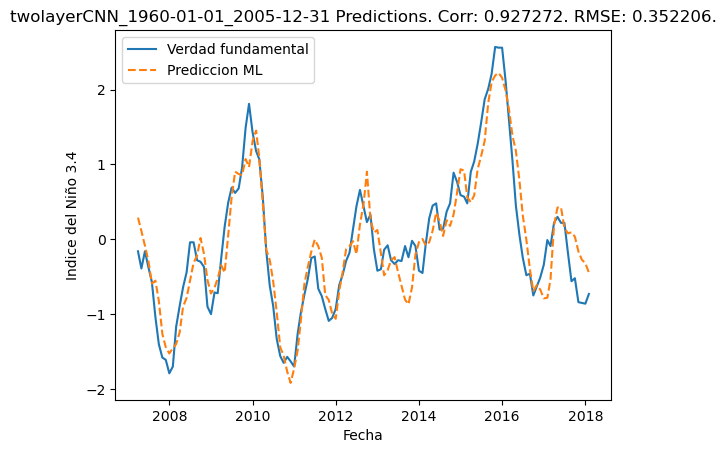

In [56]:
corr, _ = pearsonr(test_predictands, predictions)
rmse = mean_squared_error(test_predictands, predictions) ** 0.5
plot_nino_time_series(
    test_predictands,
    predictions,
    '{} Predictions. Corr: {:3f}. RMSE: {:3f}.'.format(experiment_name, corr, rmse)
    )

## Ejercicio 2

⭐ **¡Tu turno!:** Intenta reducir el número de parámetros de la red. ¡Podrías definir tu propia arquitectura de red, que utilice un número diferente de parámetros!

In [58]:
# first we'll install a helpful library to sum our parameters
!pip install torchinfo

In [59]:
from torchinfo import summary

# let's see how many parameters our original CNN has
summary(net)

Layer (type:depth-idx)                   Param #
CNN                                      --
├─Conv2d: 1-1                            114
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            2,416
├─Print: 1-4                             --
├─Linear: 1-5                            7,015,800
├─Linear: 1-6                            10,164
├─Linear: 1-7                            85
Total params: 7,028,579
Trainable params: 7,028,579
Non-trainable params: 0

In [60]:
class CNNReduced(CNN):
    def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
        """
        inputs
        -------
            num_input_time_steps        (int) : the number of input time
                                                steps in the predictor
            print_feature_dimension    (bool) : whether or not to print
                                                out the dimension of the features
                                                extracted from the conv layers
        """
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(num_input_time_steps, 3, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 16, 5)
        self.print_layer = Print()

        #TIP: print out the dimension of the extracted features from
        #the conv layers for setting the dimension of the linear layer!
        #Using the print_layer, we find that the dimensions are
        #(batch_size, 16, 42, 87)
        self.fc1 = nn.Linear(16 * 42 * 87, 100)
        self.fc2 = nn.Linear(100, 80)
        self.fc3 = nn.Linear(80, 1)

        self.print_feature_dimension = print_feature_dimension

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self.print_feature_dimension:
          x = self.print_layer(x)
        x = x.view(-1, 16 * 42 * 87)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [61]:
net_reduced = CNNReduced(num_input_time_steps=num_input_time_steps)
summary(net_reduced)

Layer (type:depth-idx)                   Param #
CNNReduced                               --
├─Conv2d: 1-1                            27
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            1,216
├─Print: 1-4                             --
├─Linear: 1-5                            5,846,500
├─Linear: 1-6                            8,080
├─Linear: 1-7                            81
Total params: 5,855,904
Trainable params: 5,855,904
Non-trainable params: 0

In [62]:
optimizer = optim.Adam(net_reduced.parameters(), lr=0.0001)

experiment_name = "reducedParametersCNN_{}_{}".format(train_start_date, train_end_date)
predictions, train_losses, test_losses = train_network(net_reduced, nn.MSELoss(),
                  optimizer, trainloader, testloader, experiment_name)

C:\Users\Cristian\AppData\Local\Temp\ipykernel_31520\2778238354.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self.predictors[idx], self.predictands[idx]
C:\Users\Cristian\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


train Set: Epoch 01. loss: 0.690194
test Set: Epoch 01. loss: 0.811419
train Set: Epoch 02. loss: 0.534618
test Set: Epoch 02. loss: 0.541621
train Set: Epoch 03. loss: 0.255546
test Set: Epoch 03. loss: 0.290050
train Set: Epoch 04. loss: 0.180074
test Set: Epoch 04. loss: 0.236285
train Set: Epoch 05. loss: 0.134994
test Set: Epoch 05. loss: 0.207540
train Set: Epoch 06. loss: 0.101483
test Set: Epoch 06. loss: 0.189556
train Set: Epoch 07. loss: 0.081469
test Set: Epoch 07. loss: 0.171165
train Set: Epoch 08. loss: 0.072158
test Set: Epoch 08. loss: 0.159735
train Set: Epoch 09. loss: 0.066725
test Set: Epoch 09. loss: 0.168461
train Set: Epoch 10. loss: 0.059317
test Set: Epoch 10. loss: 0.235211
train Set: Epoch 11. loss: 0.054610
test Set: Epoch 11. loss: 0.341069
train Set: Epoch 12. loss: 0.053207
test Set: Epoch 12. loss: 0.358034
train Set: Epoch 13. loss: 0.064806
test Set: Epoch 13. loss: 0.237212
train Set: Epoch 14. loss: 0.114509
test Set: Epoch 14. loss: 0.355162
train 

C:\Users\Cristian\AppData\Local\Temp\ipykernel_31520\2722663418.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load('{}.pt'.format(experiment_name))


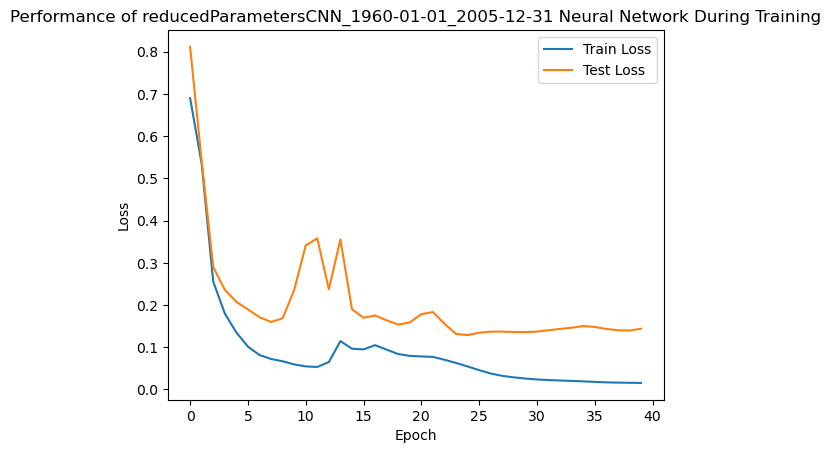

In [63]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of {} Neural Network During Training'.format(experiment_name))
plt.legend(loc='best')
plt.show()

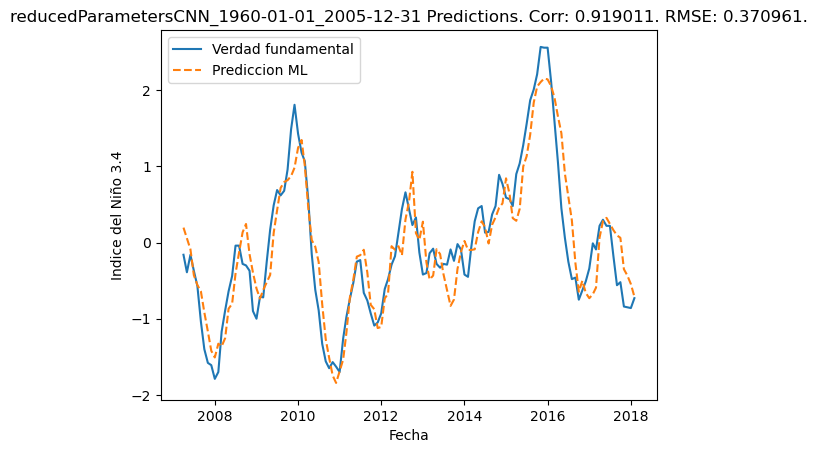

In [64]:
corr, _ = pearsonr(test_predictands, predictions)
rmse = mean_squared_error(test_predictands, predictions) ** 0.5
plot_nino_time_series(
    test_predictands,
    predictions,
    '{} Predictions. Corr: {:3f}. RMSE: {:3f}.'.format(experiment_name, corr, rmse)
    )

In this possible solution, we simply adjust the number of output layers from both the first and second linear layers.

In [66]:
class CNNReduced(CNN):
    def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
        """
        inputs
        -------
            num_input_time_steps        (int) : the number of input time
                                                steps in the predictor
            print_feature_dimension    (bool) : whether or not to print
                                                out the dimension of the features
                                                extracted from the conv layers
        """
        super(CNNReduced, self).__init__()
        self.conv1 = nn.Conv2d(num_input_time_steps, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.print_layer = Print()

        #TIP: print out the dimension of the extracted features from
        #the conv layers for setting the dimension of the linear layer!
        #Using the print_layer, we find that the dimensions are
        #(batch_size, 16, 42, 87)
        self.fc1 = nn.Linear(16 * 42 * 87, 80)
        self.fc2 = nn.Linear(80, 42)
        self.fc3 = nn.Linear(42, 1)
        self.print_feature_dimension = print_feature_dimension

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self.print_feature_dimension:
          x = self.print_layer(x)
        x = x.view(-1, 16 * 42 * 87)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [67]:
net_reduced = CNNReduced(num_input_time_steps=num_input_time_steps)
summary(net_reduced)

Layer (type:depth-idx)                   Param #
CNNReduced                               --
├─Conv2d: 1-1                            114
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            2,416
├─Print: 1-4                             --
├─Linear: 1-5                            4,677,200
├─Linear: 1-6                            3,402
├─Linear: 1-7                            43
Total params: 4,683,175
Trainable params: 4,683,175
Non-trainable params: 0

In [68]:
optimizer = optim.Adam(net_reduced.parameters(), lr=0.0001)

experiment_name = "reducedParametersCNN_{}_{}".format(train_start_date, train_end_date)
predictions, train_losses, test_losses = train_network(net_reduced, nn.MSELoss(),
                  optimizer, trainloader, testloader, experiment_name)

C:\Users\Cristian\AppData\Local\Temp\ipykernel_31520\2778238354.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self.predictors[idx], self.predictands[idx]
C:\Users\Cristian\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


train Set: Epoch 01. loss: 0.625454
test Set: Epoch 01. loss: 0.616839
train Set: Epoch 02. loss: 0.376276
test Set: Epoch 02. loss: 0.442669
train Set: Epoch 03. loss: 0.215327
test Set: Epoch 03. loss: 0.182980
train Set: Epoch 04. loss: 0.121218
test Set: Epoch 04. loss: 0.146818
train Set: Epoch 05. loss: 0.085288
test Set: Epoch 05. loss: 0.152423
train Set: Epoch 06. loss: 0.080094
test Set: Epoch 06. loss: 0.166612
train Set: Epoch 07. loss: 0.135562
test Set: Epoch 07. loss: 0.147271
train Set: Epoch 08. loss: 0.123262
test Set: Epoch 08. loss: 0.702320
train Set: Epoch 09. loss: 0.183175
test Set: Epoch 09. loss: 0.415916
train Set: Epoch 10. loss: 0.112976
test Set: Epoch 10. loss: 0.235535
train Set: Epoch 11. loss: 0.150463
test Set: Epoch 11. loss: 0.180450
train Set: Epoch 12. loss: 0.136006
test Set: Epoch 12. loss: 0.190530
train Set: Epoch 13. loss: 0.103217
test Set: Epoch 13. loss: 0.319308
train Set: Epoch 14. loss: 0.095722
test Set: Epoch 14. loss: 0.432116
train 

C:\Users\Cristian\AppData\Local\Temp\ipykernel_31520\2722663418.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load('{}.pt'.format(experiment_name))


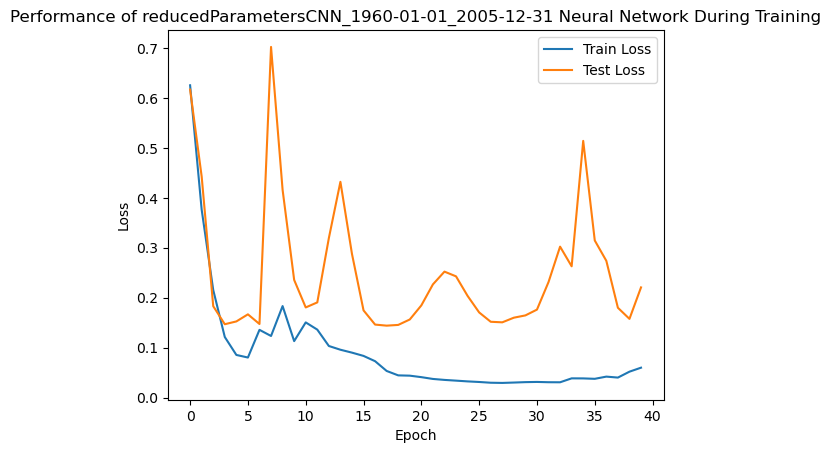

In [69]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of {} Neural Network During Training'.format(experiment_name))
plt.legend(loc='best')
plt.show()

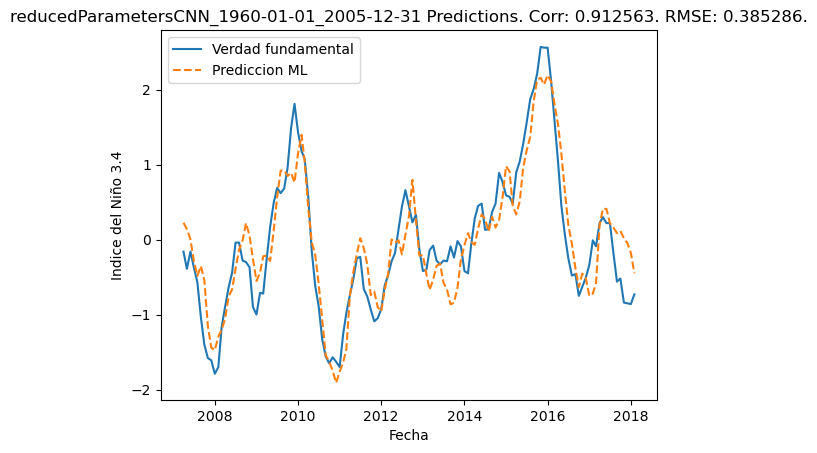

In [70]:
corr, _ = pearsonr(test_predictands, predictions)
rmse = mean_squared_error(test_predictands, predictions) ** 0.5
plot_nino_time_series(
    test_predictands,
    predictions,
    '{} Predictions. Corr: {:3f}. RMSE: {:3f}.'.format(experiment_name, corr, rmse)
    )

We see that this new architecture lowered the losses on the validation set and also lowered our RMSE by about 0.03.

## Exercise 3

⭐ **Tu turno!:** Intenta usar modelos ML tradicionales de sklearn para esta tarea.  Tenga en cuenta que estos algoritmos no aprovechan la naturaleza espacial de los conjuntos de datos cuadriculados.  Por lo tanto, requieren que el argumento `data_format` se establezca en `plano`: los predictores tienen la forma `(num_samples,lat*lon*num_time_steps)`.

In [73]:
train_start_date = '1990-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 1
lead_time = 4
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'flatten',
                      num_input_time_steps=num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'flatten',
                    num_input_time_steps=num_input_time_steps)

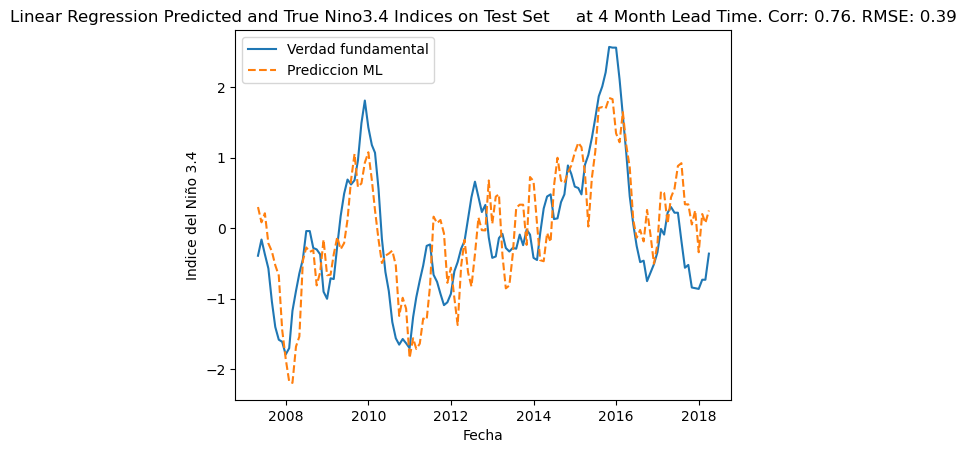

In [74]:
# use sklearn's linear regression algorithm
regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(train_predictors, train_predictands)

sklearn_predictions = regr_1_month_lr.predict(test_predictors)
corr, _ = scipy.stats.pearsonr(sklearn_predictions, test_predictands)
rmse = mean_squared_error(sklearn_predictions, test_predictands)
plot_nino_time_series(test_predictands, sklearn_predictions,
    'Linear Regression Predicted and True Nino3.4 Indices on Test Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

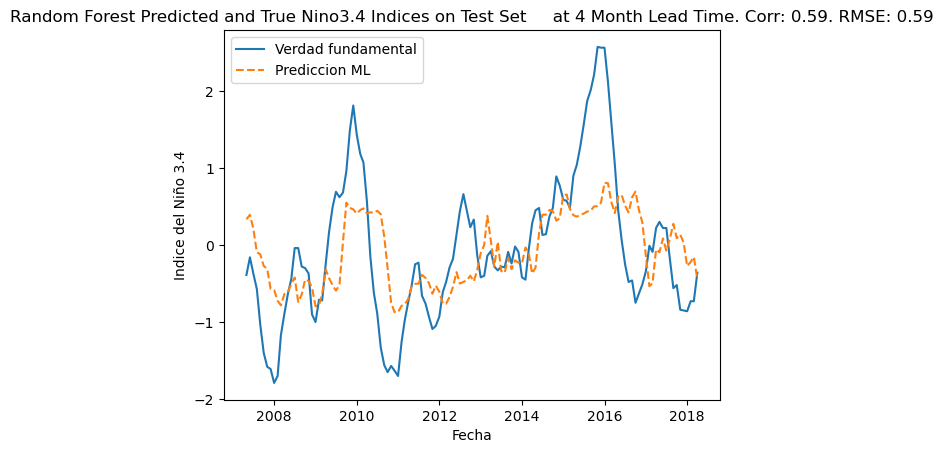

In [75]:
# now try using sklearn's random forest regression algorithm
# HINT: you may need to play around with the algorithm's hyperparameters
regr_1_month_rf = sklearn.ensemble.RandomForestRegressor(max_depth=2, random_state=0)
regr_1_month_rf.fit(train_predictors, train_predictands)

sklearn_predictions_rf = regr_1_month_rf.predict(test_predictors)
corr, _ = scipy.stats.pearsonr(sklearn_predictions_rf, test_predictands)
rmse = mean_squared_error(sklearn_predictions_rf, test_predictands)
plot_nino_time_series(test_predictands, sklearn_predictions_rf,
    'Random Forest Predicted and True Nino3.4 Indices on Test Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

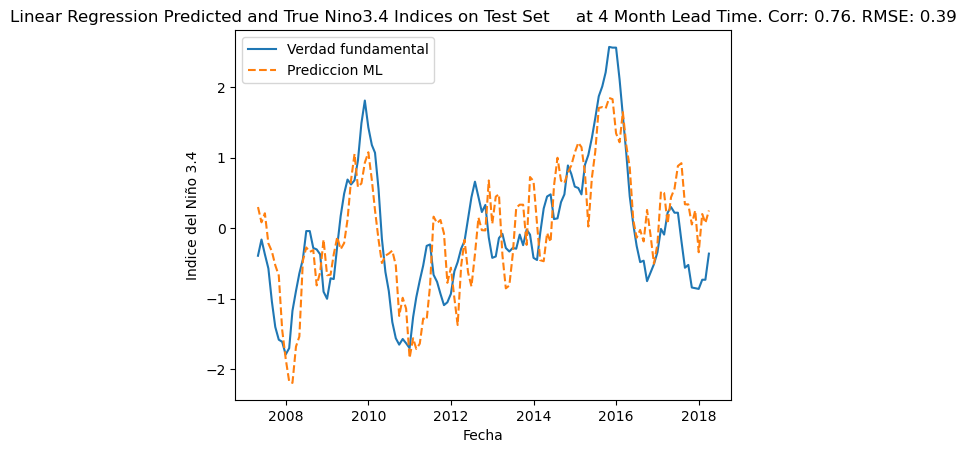

In [76]:
# use sklearn's linear regression algorithm
regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(train_predictors, train_predictands)

sklearn_predictions = regr_1_month_lr.predict(test_predictors)
corr, _ = scipy.stats.pearsonr(sklearn_predictions, test_predictands)
rmse = mean_squared_error(sklearn_predictions, test_predictands)
plot_nino_time_series(test_predictands, sklearn_predictions,
    'Linear Regression Predicted and True Nino3.4 Indices on Test Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

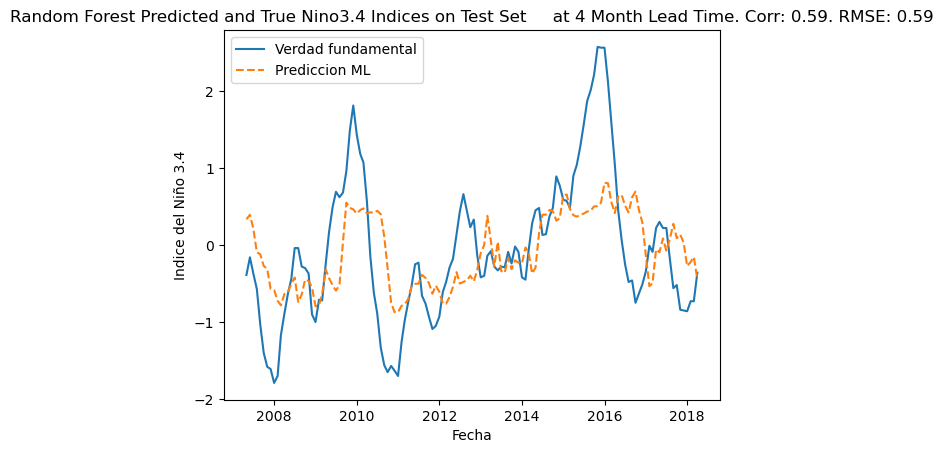

In [77]:
# now try using sklearn's random forest regression algorithm
regr_1_month_rf = sklearn.ensemble.RandomForestRegressor(max_depth=2, random_state=0)
regr_1_month_rf.fit(train_predictors, train_predictands)

sklearn_predictions_rf = regr_1_month_rf.predict(test_predictors)
corr, _ = scipy.stats.pearsonr(sklearn_predictions_rf, test_predictands)
rmse = mean_squared_error(sklearn_predictions_rf, test_predictands)
plot_nino_time_series(test_predictands, sklearn_predictions_rf,
    'Random Forest Predicted and True Nino3.4 Indices on Test Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

We see significantly better performance with the random forest model!

## Ejercicio de desafío: ¿Qué fuentes de datos mejoran el algoritmo ML? ¿Qué fuentes de datos no mejoran el algoritmo ML?

Intentemos entrenar nuestro modelo de previsión ENSO con datos antiguos (es decir, de principios del siglo XX) del conjunto de datos de TSM de Cobe.  La incertidumbre es mucho mayor con estos datos que con los más recientes, ya que la teledetección y las fuentes de datos han mejorado.

**OBJETIVO DE ESTE EJERCICIO**: generar dos gráficos: uno mostrando las series temporales de los índices Niño3.4 predichos y reales con un modelo ML entrenado con datos de 1900-1930.  El otro debería mostrar la misma serie temporal de índices Niño3.4 predichos y reales con un modelo entrenado con datos de 1975-2005.  (Ambos algoritmos entrenados deberían probarse con datos de 2007-2018).

### Usando un modelo de regresion lineal
Generamos dos graficos para mostrar las series temporales de los índices Niño3.4 predichos y reales 

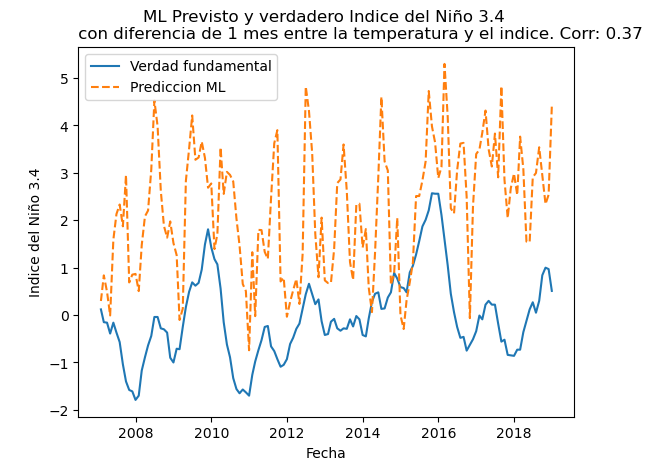

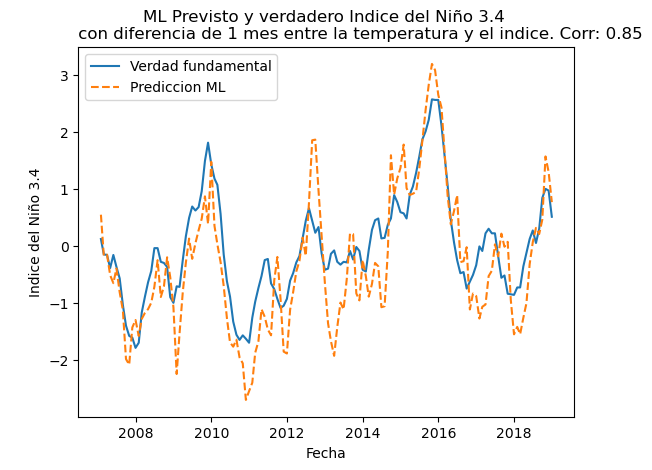

In [81]:
for train_start_date, train_end_date in [("1900-01-01", "1930-12-31"), ("1975-01-01", "2005-12-31")]:

    ##
    X_train, y_train = assemble_basic_predictors_predictands(train_start_date,train_end_date, lead_time=1)
    X_test, y_test = assemble_basic_predictors_predictands('2007-01-01','2018-12-31', lead_time=1)
    
    regr = sklearn.linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    
    predictions_test = regr.predict(X_test)
    corr, _ = scipy.stats.pearsonr(predictions_test, y_test)

    plot_nino_time_series(y_test, predictions_test,
            'ML Previsto y verdadero Indice del Niño 3.4 \n \
            con diferencia de 1 mes entre la temperatura y el indice. Corr: {:.2f}'.format(corr))


En el grafico 1 se puede observar como las fuentes de datos antiguas no mejoran el modelo
En el grafico 2 se observa como las fuentes de datos mas recientes mejoran el modelo

### Usando un modelo de CNN
Generamos dos graficos para mostrar las series temporales de los índices Niño3.4 predichos y reales usando un modelo de deep learning

C:\Users\Cristian\AppData\Local\Temp\ipykernel_31520\2778238354.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self.predictors[idx], self.predictands[idx]
C:\Users\Cristian\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


train Set: Epoch 01. loss: 0.538309
test Set: Epoch 01. loss: 0.899835
train Set: Epoch 02. loss: 0.508126
test Set: Epoch 02. loss: 0.868582
train Set: Epoch 03. loss: 0.477830
test Set: Epoch 03. loss: 0.830270
train Set: Epoch 04. loss: 0.422188
test Set: Epoch 04. loss: 0.777659
train Set: Epoch 05. loss: 0.313597
test Set: Epoch 05. loss: 0.837727
train Set: Epoch 06. loss: 0.204293
test Set: Epoch 06. loss: 0.836925
train Set: Epoch 07. loss: 0.135165
test Set: Epoch 07. loss: 0.967455
train Set: Epoch 08. loss: 0.119501
test Set: Epoch 08. loss: 0.992954
train Set: Epoch 09. loss: 0.105760
test Set: Epoch 09. loss: 1.236365
train Set: Epoch 10. loss: 0.096195
test Set: Epoch 10. loss: 1.320876
train Set: Epoch 11. loss: 0.089067
test Set: Epoch 11. loss: 1.631030
train Set: Epoch 12. loss: 0.084352
test Set: Epoch 12. loss: 1.838212
train Set: Epoch 13. loss: 0.081977
test Set: Epoch 13. loss: 2.011509
train Set: Epoch 14. loss: 0.081841
test Set: Epoch 14. loss: 2.201784
train 

C:\Users\Cristian\AppData\Local\Temp\ipykernel_31520\2722663418.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load('{}.pt'.format(experiment_name))


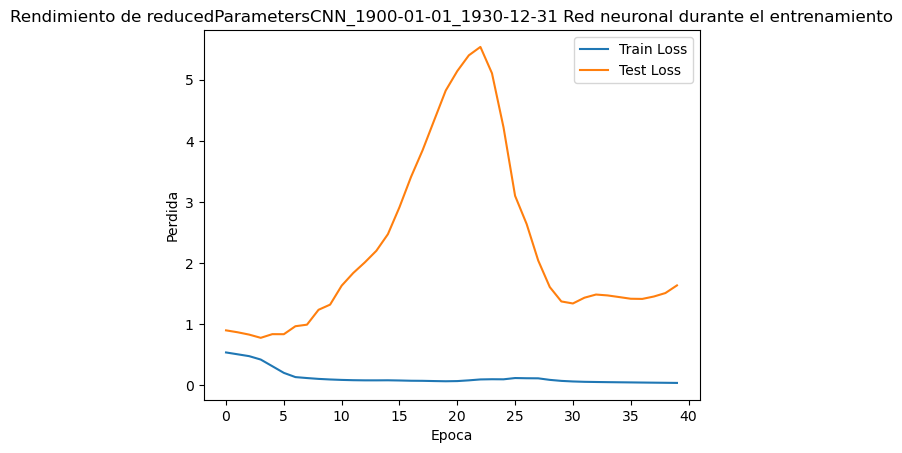

C:\Users\Cristian\AppData\Local\Temp\ipykernel_31520\2778238354.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self.predictors[idx], self.predictands[idx]
C:\Users\Cristian\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


train Set: Epoch 01. loss: 0.676422
test Set: Epoch 01. loss: 0.505004
train Set: Epoch 02. loss: 0.358871
test Set: Epoch 02. loss: 0.253932
train Set: Epoch 03. loss: 0.212350
test Set: Epoch 03. loss: 0.261590
train Set: Epoch 04. loss: 0.153988
test Set: Epoch 04. loss: 0.518013
train Set: Epoch 05. loss: 0.133679
test Set: Epoch 05. loss: 0.344171
train Set: Epoch 06. loss: 0.189490
test Set: Epoch 06. loss: 0.279867
train Set: Epoch 07. loss: 0.220461
test Set: Epoch 07. loss: 0.307284
train Set: Epoch 08. loss: 0.110991
test Set: Epoch 08. loss: 0.248757
train Set: Epoch 09. loss: 0.170665
test Set: Epoch 09. loss: 0.425136
train Set: Epoch 10. loss: 0.214052
test Set: Epoch 10. loss: 0.776436
train Set: Epoch 11. loss: 0.134078
test Set: Epoch 11. loss: 0.223337
train Set: Epoch 12. loss: 0.135790
test Set: Epoch 12. loss: 0.207694
train Set: Epoch 13. loss: 0.063385
test Set: Epoch 13. loss: 0.252777
train Set: Epoch 14. loss: 0.045081
test Set: Epoch 14. loss: 0.282481
train 

C:\Users\Cristian\AppData\Local\Temp\ipykernel_31520\2722663418.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load('{}.pt'.format(experiment_name))


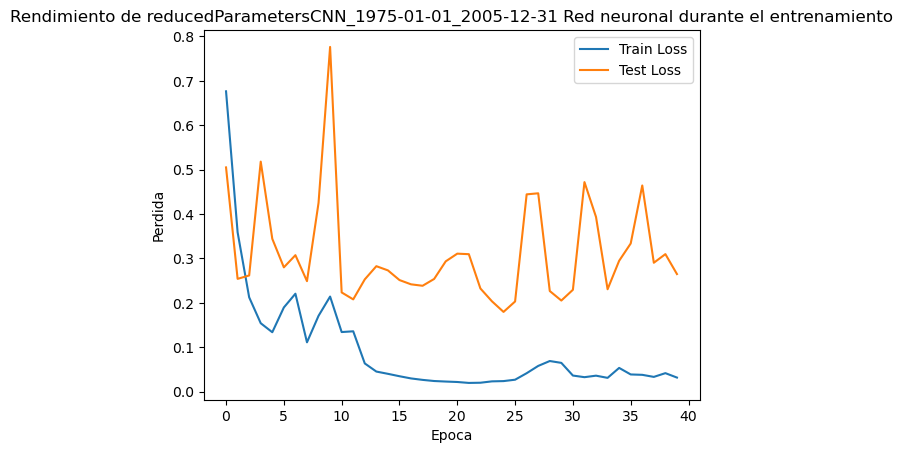

In [84]:
for train_start_date, train_end_date in [("1900-01-01", "1930-12-31"), ("1975-01-01", "2005-12-31")]:
    num_input_time_steps = 2
    lead_time = 2
    train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)
    test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)

    train_dataset = ENSODataset(train_predictors, train_predictands)
    test_dataset = ENSODataset(test_predictors, test_predictands)

    trainloader = DataLoader(train_dataset, batch_size=10)
    testloader = DataLoader(test_dataset, batch_size=10)
    net_reduced_challenge = CNNReduced(num_input_time_steps=num_input_time_steps)
    optimizer = optim.Adam(net_reduced_challenge.parameters(), lr=0.0001)
    
    experiment_name = "reducedParametersCNN_{}_{}".format(train_start_date, train_end_date)
    predictions, train_losses, test_losses = train_network(net_reduced_challenge, nn.MSELoss(),
                      optimizer, trainloader, testloader, experiment_name)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoca')
    plt.ylabel('Perdida')
    plt.title('Rendimiento de {} Red neuronal durante el entrenamiento'.format(experiment_name))
    plt.legend(loc='best')
    plt.show()

En el Modelo 1 de deep learning se puede observar como las fuentes de datos antiguas no mejoran el modelo
En el Modelo 1 de deep learning se observa como las fuentes de datos mas recientes mejoran el modelo

## Ejercicio de desafío: Manipulación de datos: ¿Los algoritmos de aprendizaje automático funcionan mejor con un problema de clasificación o de regresión?

Convierta el problema de regresión (predicción de un valor continuo) en clasificación (predicción de un valor discreto).  En este caso, el valor continuo es el valor exacto del índice Niño3.4.  

Dividamos el índice Niño3.4 en dos valores: 0 y 1. Digamos que los valores negativos del índice Niño3.4 deben asignarse a 0 y los valores positivos del índice deben asignarse a 1.

### Objetivo del ejercicio:

Entrenar una red neuronal y un modelo de regresión logística sklearn para predecir 0 o 1 correspondiente al mapeo anterior.  Intente cambiar la función de pérdida de la red neuronal de `nn.MSELoss` a `nn.BCEWithLogitsLoss`.

Usando las fuentes de datos recientes agregamos un nuevo argumento llamado clasificacion en la funcion train_network con esto conseguimos que el indice del niño sea binario, conviertiendo el problema en uno de clasificacion. Usamos una nueva funcion de perdida especial para problemas de clasificacion "BCEWithLogitsLoss"  

C:\Users\Cristian\AppData\Local\Temp\ipykernel_31520\2778238354.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self.predictors[idx], self.predictands[idx]


train Set: Epoch 01. loss: 0.693120
test Set: Epoch 01. loss: 0.690086
train Set: Epoch 02. loss: 0.676510
test Set: Epoch 02. loss: 0.677975
train Set: Epoch 03. loss: 0.658269
test Set: Epoch 03. loss: 0.665322
train Set: Epoch 04. loss: 0.639171
test Set: Epoch 04. loss: 0.649473
train Set: Epoch 05. loss: 0.615302
test Set: Epoch 05. loss: 0.628724
train Set: Epoch 06. loss: 0.585430
test Set: Epoch 06. loss: 0.603440
train Set: Epoch 07. loss: 0.552556
test Set: Epoch 07. loss: 0.575794
train Set: Epoch 08. loss: 0.518072
test Set: Epoch 08. loss: 0.546002
train Set: Epoch 09. loss: 0.482147
test Set: Epoch 09. loss: 0.517373
train Set: Epoch 10. loss: 0.447057
test Set: Epoch 10. loss: 0.489459
train Set: Epoch 11. loss: 0.414362
test Set: Epoch 11. loss: 0.463484
train Set: Epoch 12. loss: 0.384459
test Set: Epoch 12. loss: 0.439886
train Set: Epoch 13. loss: 0.357472
test Set: Epoch 13. loss: 0.418757
train Set: Epoch 14. loss: 0.333582
test Set: Epoch 14. loss: 0.400297
train 

C:\Users\Cristian\AppData\Local\Temp\ipykernel_31520\2722663418.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load('{}.pt'.format(experiment_name))


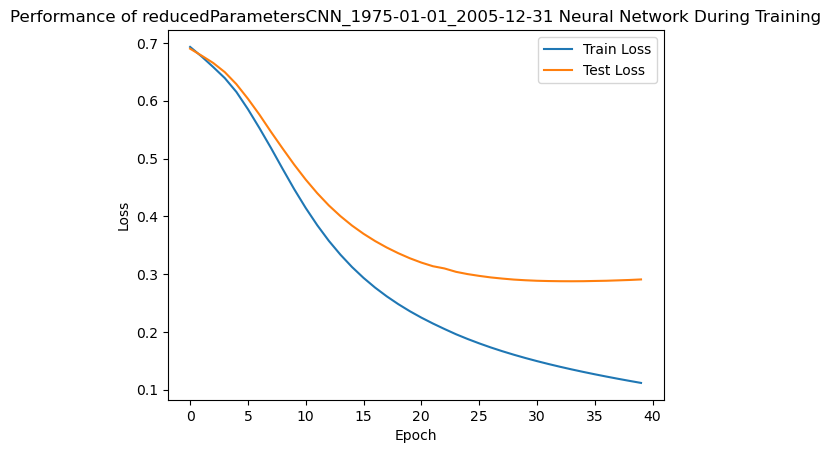

In [88]:
train_start_date, train_end_date = ("1975-01-01", "2005-12-31")
cnn_num_input_time_steps = 3
lead_time = 2
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                  train_end_date, lead_time, 'observations', 'spatial', num_input_time_steps=cnn_num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                '2017-12-31', lead_time, 'observations', 'spatial', num_input_time_steps=cnn_num_input_time_steps)

train_dataset = ENSODataset(train_predictors, train_predictands)
test_dataset = ENSODataset(test_predictors, test_predictands)


trainloader = DataLoader(train_dataset, batch_size=10)     
testloader = DataLoader(test_dataset, batch_size=10)
net_reduced_challenge2 = CNNReduced(num_input_time_steps=cnn_num_input_time_steps)
optimizer = optim.Adam(net_reduced_challenge2.parameters(), lr=0.00001)
experiment_name = "reducedParametersCNN_{}_{}".format(train_start_date, train_end_date)
predictions, train_losses, test_losses = train_network(net_reduced_challenge2, nn.BCEWithLogitsLoss(),
                  optimizer, trainloader, testloader, experiment_name,classification=True)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of {} Neural Network During Training'.format(experiment_name))
plt.legend(loc='best')
plt.show()

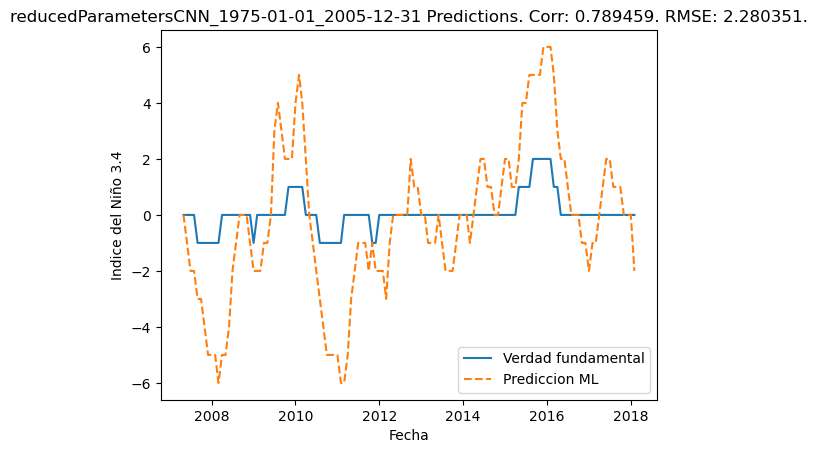

Accuracy: 0.2153846153846154
Precision: 0.08058608058608059
Recall: 0.2153846153846154
F1-score: 0.2153846153846154
Confusion Matrix:
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  7  2  3  2  1  0  0  0  0  0  0  0]
 [ 1  3  1  2 15 20 27 13 11  2  1  0  0]
 [ 0  0  0  0  0  0  0  0  3  1  4  3  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  3  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]]


C:\Users\Cristian\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [89]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Ensure predictions are integers
predictions = predictions.astype(int)

# Ensure test_predictands are integers
test_predictands = test_predictands.astype(int)
corr, _ = pearsonr(test_predictands, predictions)
rmse = mean_squared_error(test_predictands, predictions) ** 0.5
plot_nino_time_series(
    test_predictands,
    predictions,
    '{} Predictions. Corr: {:3f}. RMSE: {:3f}.'.format(experiment_name, corr, rmse)
    )
accuracy = accuracy_score(test_predictands, predictions)
precision = precision_score(test_predictands, predictions, average='macro')
recall = recall_score(test_predictands, predictions, average='weighted')
f1 = f1_score(test_predictands, predictions, average='micro')
conf_matrix = confusion_matrix(test_predictands, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)


En este caso los algoritmos de aprendizaje automático funcionan mejor con un problema de regresión ya que de acuerdo a las metricas se puede observar poca precision en las predicciones, como clasificamos los datos genero un imbalance 


# Ejercicio de desafío: ¡Consiga el mejor algoritmo de previsión ENSO!  (Consejo: compruebe el ensamblaje entre algoritmos y pruebe el ajuste de hiperparámetros).

¿Ayudan las redes neuronales más profundas con más capas convolucionales?
Pruebe a cambiar los hiperparámetros de la red neuronal

* la tasa de aprendizaje
* la elección del optimizador
* el tamaño de los filtros de convolución
* el número de filtros de convolución
* el número de pesos en las capas totalmente conectadas

Hay otros parámetros de preprocesamiento de datos que pueden mejorar el rendimiento de su algoritmo de previsión:

* Entrenar el modelo ML en una «porción» específica de latitud o longitud, en lugar de en todo el planeta.
* Ensamblar predicciones de varios algoritmos diferentes. Por ejemplo, podría promediar la predicción de bosques aleatorios, redes neuronales artificiales, redes neuronales convolucionales y/o cualquier otro modelo de aprendizaje automático.

Recordemos el cuaderno anterior: los modelos con muchos parámetros (es decir, redes neuronales muy profundas o árboles de decisión muy profundos) tienen más probabilidades de tener un sesgo muy bajo y una varianza muy alta: ¡probablemente se ajustarán en exceso!


*Desarrolla un sistema de previsión Nino3.4 para un lead_time de 5 meses...* Si quieres, envía tus resultados al enlace kaggle:

Detalles del concurso kaggle: al igual que en la primera celda de código, probaremos nuestro código con datos de 2007-01-01 a 2017-12-31.  El cargador de datos se reproduce a continuación.  Hay 131 pares predictor/predictando entre estas fechas.  Por lo tanto, ¡tu entrada debe tener exactamente 131 números!  

## Ultimate Submission Code
Primero definimos los parametros de nuestros dos modelos a entrenar. Definimos los datos para el modelo de regresion lineal y el modelo de aprendizaje profundo

In [95]:
#Select the data parameters for your model(s)!
lead_time = 5
data_format = 'flatten'
cnn_data_format = 'spatial'
lat_slice = None#slice(-50, -80) #rango 90 a -90
lon_slice = None#slice(100, 355) #rango 0 a 360
num_input_time_steps = 3 #Do not change this!
use_pca = False
n_components = 5
train_predictors, train_predictands = assemble_predictors_predictands('1987-12-31',
                    '1998-12-31', lead_time=5, dataset='observations',
                    data_format=data_format, num_input_time_steps=num_input_time_steps,
                    use_pca=use_pca, n_components=n_components, lat_slice=lat_slice, lon_slice=lon_slice)
#Do not change the line below for your kaggle submission
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time=5, dataset='observations',
                    data_format=data_format, num_input_time_steps=num_input_time_steps,
                    use_pca=use_pca, n_components=n_components, lat_slice=lat_slice, lon_slice=lon_slice)

cnn_train_predictors, cnn_train_predictands = assemble_predictors_predictands('1987-12-31',
                    '1998-12-31', lead_time=5, dataset='observations',
                    data_format=cnn_data_format, num_input_time_steps=num_input_time_steps,
                    use_pca=use_pca, n_components=n_components, lat_slice=lat_slice, lon_slice=lon_slice)
#Do not change the line below for your kaggle submission
cnn_test_predictors, cnn_test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time=5, dataset='observations',
                    data_format=cnn_data_format, num_input_time_steps=num_input_time_steps,
                    use_pca=use_pca, n_components=n_components, lat_slice=lat_slice, lon_slice=lon_slice)



### Regresion lineal

0.5860836535692215


C:\Users\Cristian\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


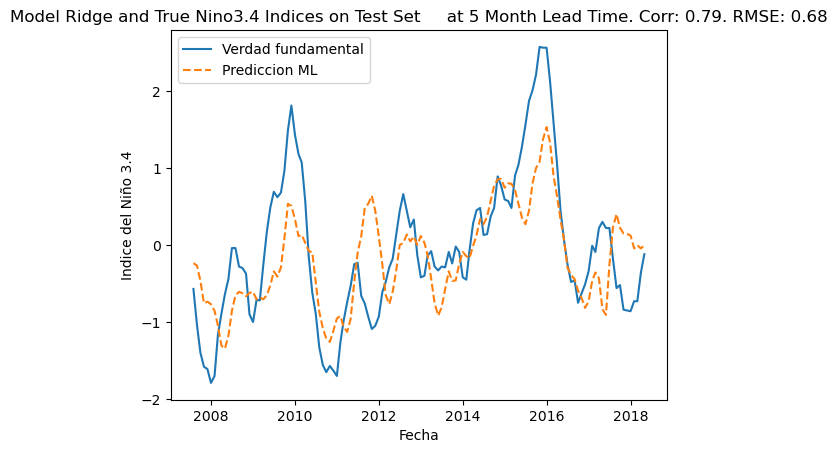

In [98]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor

#sklearn_model = sklearn.ensemble.RandomForestRegressor(max_depth=7, random_state=42,max_features = 0.1, n_estimators = 100)
sklearn_model = sklearn.linear_model.Ridge(alpha=6400.0)
scores = cross_val_score(sklearn_model,
                         train_predictors, train_predictands,
                         cv=5,
                         scoring='neg_mean_squared_error')
rmse_score_tr = -1*scores.mean()
print(rmse_score_tr)
sklearn_model.fit(train_predictors,train_predictands)
sklearn_predictions = sklearn_model.predict(test_predictors)
rmse = mean_squared_error(sklearn_predictions, test_predictands, squared=False)
plot_nino_time_series(test_predictands, sklearn_predictions,
    'Model Ridge and True Nino3.4 Indices on Test Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))


### Aprendizaje profundo

In [101]:
class CNNChallenge(CNN):
    def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
        """
        inputs
        -------
            num_input_time_steps        (int) : the number of input time
                                                steps in the predictor
            print_feature_dimension    (bool) : whether or not to print
                                                out the dimension of the features
                                                extracted from the conv layers
        """
        super(CNNChallenge, self).__init__()
        self.conv1 = nn.Conv2d(num_input_time_steps, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 16, 5)
        self.print_layer = Print()

        #TIP: print out the dimension of the extracted features from
        #the conv layers for setting the dimension of the linear layer!
        #Using the print_layer, we find that the dimensions are
        #(batch_size, 16, 42, 87)
        self.fc1 = nn.Linear(16 * 42 * 87, 80)
        self.fc2 = nn.Linear(80, 42)
        self.fc3 = nn.Linear(42, 1)
        self.print_feature_dimension = print_feature_dimension

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self.print_feature_dimension:
          x = self.print_layer(x)
        x = x.view(-1, 16 * 42 * 87)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [103]:
#If using deep learning:
# create an ENSODataset and DataLoader
#object (see code cell in Exercise 1) and use the `train_network` method to
#extract predictions!
#cnn_predictions, _, _ = train_network()
cnn_train_dataset = ENSODataset(cnn_train_predictors, cnn_train_predictands)
cnn_test_dataset = ENSODataset(cnn_test_predictors, cnn_test_predictands)
cnn_trainloader = DataLoader(cnn_train_dataset, batch_size=10)
cnn_testloader = DataLoader(cnn_test_dataset, batch_size=10)
net_challenge = CNNChallenge(num_input_time_steps=num_input_time_steps)
cnn_optimizer = optim.SGD(net_challenge.parameters(), lr=0.0001,momentum=1.0)

cnn_predictions, cnn_train_losses, cnn_test_losses = train_network(net_challenge, nn.MSELoss(),
                  cnn_optimizer, cnn_trainloader, cnn_testloader, experiment_name)

C:\Users\Cristian\AppData\Local\Temp\ipykernel_31520\2778238354.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self.predictors[idx], self.predictands[idx]


train Set: Epoch 01. loss: 0.946476
test Set: Epoch 01. loss: 0.889103
train Set: Epoch 02. loss: 0.900718
test Set: Epoch 02. loss: 0.884586
train Set: Epoch 03. loss: 0.867657
test Set: Epoch 03. loss: 0.864708
train Set: Epoch 04. loss: 0.792369
test Set: Epoch 04. loss: 0.800037
train Set: Epoch 05. loss: 0.658592
test Set: Epoch 05. loss: 0.696942
train Set: Epoch 06. loss: 0.425584
test Set: Epoch 06. loss: 0.578237
train Set: Epoch 07. loss: 0.370098
test Set: Epoch 07. loss: 0.845723
train Set: Epoch 08. loss: 0.488236
test Set: Epoch 08. loss: 0.717433
train Set: Epoch 09. loss: 0.200176
test Set: Epoch 09. loss: 0.565688
train Set: Epoch 10. loss: 0.239107
test Set: Epoch 10. loss: 0.759605
train Set: Epoch 11. loss: 0.287885
test Set: Epoch 11. loss: 0.689429
train Set: Epoch 12. loss: 0.267872
test Set: Epoch 12. loss: 0.622268
train Set: Epoch 13. loss: 0.269949
test Set: Epoch 13. loss: 0.595154
train Set: Epoch 14. loss: 0.258205
test Set: Epoch 14. loss: 0.554391
train 

C:\Users\Cristian\AppData\Local\Temp\ipykernel_31520\2722663418.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load('{}.pt'.format(experiment_name))


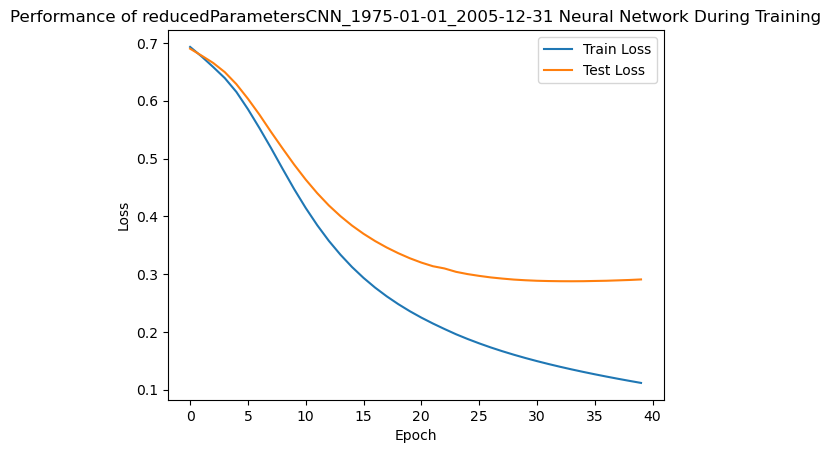

In [104]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of {} Neural Network During Training'.format(experiment_name))
plt.legend(loc='best')
plt.show()

C:\Users\Cristian\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


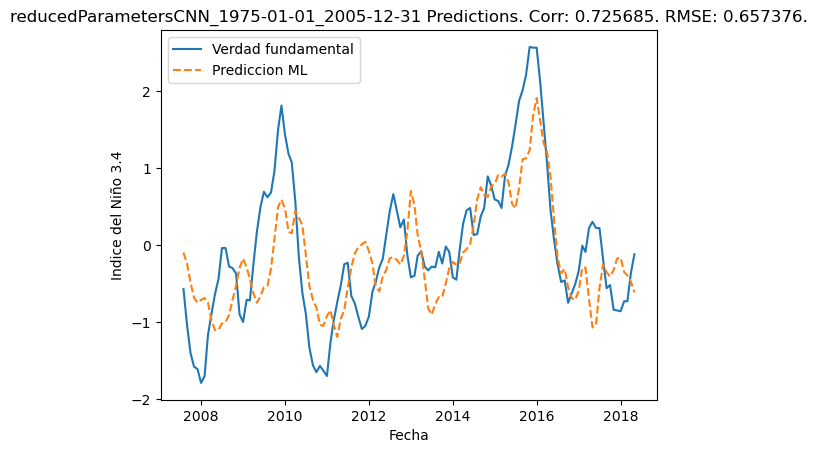

In [105]:
corr, _ = pearsonr(cnn_test_predictands, cnn_predictions)
rmse = mean_squared_error(cnn_test_predictands, cnn_predictions, squared=False)
plot_nino_time_series(
    cnn_test_predictands,
    cnn_predictions,
    '{} Predictions. Corr: {:3f}. RMSE: {:3f}.'.format(experiment_name, corr, rmse)
    )

Juntamos las predicciones de los dos algoritmos

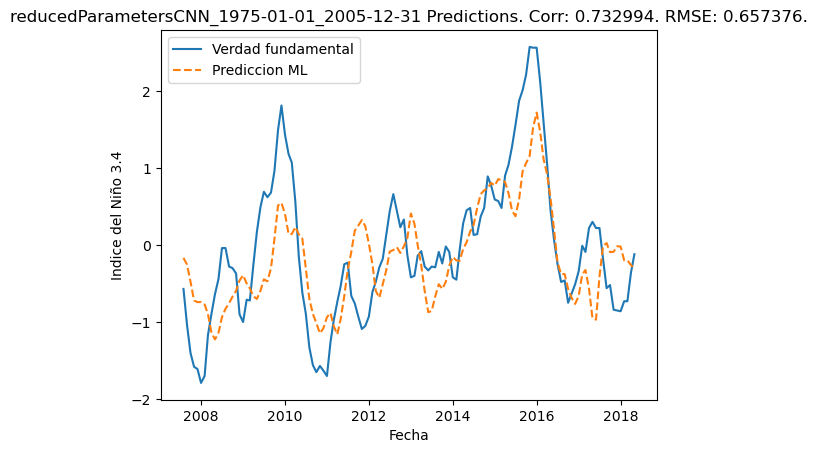

In [107]:
merge_predictions = (cnn_predictions +sklearn_predictions)/2.0
corr, _ = pearsonr(test_predictands, merge_predictions)
rmse = mean_squared_error(test_predictands, cnn_predictions) ** 0.5
plot_nino_time_series(
    test_predictands,
    merge_predictions,
    '{} Predictions. Corr: {:3f}. RMSE: {:3f}.'.format(experiment_name, corr, rmse)
    )